# Estimate by modelization the evolution of FED FUNDS Rate in USA

Using : 
- SPX
- Inflation 
- Unemployement 
- and past history of FEDFUNDS

## Import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
#from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context='paper', style='whitegrid')

## Definitions

In [2]:

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
#openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
#openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))

# unemployment
path_unemployment = "data/UNRATE.csv"
# federal funds rate
path_rate = "data/FEDFUNDS.csv"
# inflation
path_inflation = "data/CPIAUCSL_08_2024.csv"

ratio_test = 0.017


## Load data

- unemployment data :  https://www.bls.gov/charts/employment-situation/civilian-unemployment-rate.htm# 
    - less data :  https://fred.stlouisfed.org/series/UNRATE
- Interest rate :  https://fred.stlouisfed.org/series/FEDFUNDS
- INFLATION : https://www.usinflationcalculator.com/inflation/current-inflation-rates/
   - calculated from CPI : https://fred.stlouisfed.org/series/CPIAUCSL  
   Inflation = 100 * [ CPI(month, year) - CPI(month, year-1) ] / CPI(month, year-1)
- SPX SP500 : Yahoo Finance Ticker ^GSPC but history limited to 1985
  - So Use date copy paste table from  https://www.multpl.com/s-p-500-historical-prices/table/by-month if no update needed


In [3]:
# load local data
# load unemployment
df_unemployment = pd.read_csv(path_unemployment)
df_unemployment["DATE"] = pd.to_datetime(df_unemployment["DATE"])
df_unemployment.rename(columns={"UNRATE": "Total"}, inplace=True)
# load federal funds rate
df_rate = pd.read_csv(path_rate)
df_rate["DATE"] = pd.to_datetime(df_rate["DATE"])
# load inflation
df_inflation = pd.read_csv(path_inflation)
df_inflation["DATE"] = pd.to_datetime(df_inflation["DATE"])

In [4]:
df_unemployment.rename(columns={"Total": "UNRATE"}, inplace=True)
df_unemployment

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
915,2024-04-01,3.9
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3


In [5]:
# check unemployment nan into df_unemployment 
# assert that nothing is nan
assert df_unemployment.isna().sum().sum() == 0

In [6]:
# calculatate inflation
df_inflation["CPI-12"]= df_inflation["CPIAUCSL"].shift(12)
df_inflation["Inflation"] = 100 * (df_inflation["CPIAUCSL"] - df_inflation["CPI-12"]) / df_inflation["CPI-12"]
df_inflation.tail(20)

,DATE,CPIAUCSL,CPI-12,Inflation
912,2023-01-01,300.356,282.390,6.362123
913,2023-02-01,301.509,284.535,5.965523
914,2023-03-01,301.744,287.553,4.935090
915,2023-04-01,303.032,288.764,4.941059
916,2023-05-01,303.365,291.359,4.120690
917,2023-06-01,304.003,294.996,3.053262
918,2023-07-01,304.628,294.977,3.271781
919,2023-08-01,306.187,295.209,3.718721
920,2023-09-01,307.288,296.341,3.694055
921,2023-10-01,307.531,297.863,3.245787


In [7]:
df = df_unemployment.merge(df_inflation.filter(["DATE", "Inflation"]), on="DATE", how="left")

df.tail(12)

,DATE,UNRATE,Inflation
908,2023-09-01,3.8,3.694055
909,2023-10-01,3.8,3.245787
910,2023-11-01,3.7,3.139482
911,2023-12-01,3.7,3.323160
912,2024-01-01,3.7,3.105981
913,2024-02-01,3.9,3.165743
914,2024-03-01,3.8,3.475131
915,2024-04-01,3.9,3.357731
916,2024-05-01,4.0,3.250210
917,2024-06-01,4.1,2.975629


In [8]:
df["num_month"] = df["DATE"].dt.month

In [9]:
df_rate

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
837,2024-04-01,5.33
838,2024-05-01,5.33
839,2024-06-01,5.33
840,2024-07-01,5.33


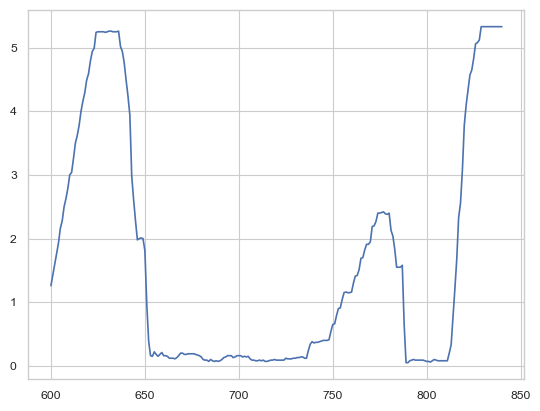

In [10]:
plt.plot(df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"])

In [11]:
# add funds rate to df
df = df.merge(df_rate, on="DATE", how="left")
#df["FEDFUNDS"] = df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"].values
df


,DATE,UNRATE,Inflation,num_month,FEDFUNDS
0,1948-01-01,3.4,10.242086,1,NaN
1,1948-02-01,3.8,9.481961,2,NaN
2,1948-03-01,4.0,6.818182,3,NaN
3,1948-04-01,3.9,8.272727,4,NaN
4,1948-05-01,3.5,9.384966,5,NaN
...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,4,5.33
916,2024-05-01,4.0,3.250210,5,5.33
917,2024-06-01,4.1,2.975629,6,5.33
918,2024-07-01,4.3,2.923566,7,5.33


In [12]:
# add the indice SPX from yahoo finance
date_start = df["DATE"].min().strftime("%Y-%m-%d")
date_end = df["DATE"].max().strftime("%Y-%m-%d")

updating = False
if updating:
    # check if data/SPX.csv exists and if last date is the last date of df
    if os.path.exists("data/SPX.csv"):
        df_spx = pd.read_csv("data/SPX.csv")
        last_date = df_spx["DATE"].max()
        if last_date >= date_end:
            print("SPX data is up to date")
            updating = False
        else:
            print("SPX data is not up to date")
            updating = True
    else:
        print("SPX data is not up to date")
        updating = True

    if updating:
        print("Updating...")
        df_spx = yf.Ticker("^GSPC").history(
                start=date_start, interval="1mo")
        df_spx = df_spx[["Close"]]
        df_spx["DATE"] = df_spx.index
        df_spx["DATE"] = df_spx["DATE"].dt.strftime("%Y-%m-%d")
        df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
        df_spx.to_csv("data/SPX.csv", index=False)
        print("SPX data is updated")
    else:
        df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
else:
    # read historical data
    df_spx = pd.read_csv("data/SP500_history.csv")
    # Rename the columns
    df_spx.rename(columns={"Date": "DATE", "Value": "Close"}, inplace=True)

    # Convert the date format and clean the 'Close' values by removing commas
    df_spx["DATE"] = pd.to_datetime(df_spx["DATE"], format="%b %d, %Y").dt.strftime("%Y-%m-%d")
    df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
    # sort by "DATE"
    df_spx.sort_values(by="DATE", inplace=True)
    df_spx["Close"] = df_spx["Close"].str.replace(",", "").astype(float)

# Display 
df_spx

,DATE,Close
1844,1871-01-01,4.44
1843,1871-02-01,4.50
1842,1871-03-01,4.61
1841,1871-04-01,4.74
1840,1871-05-01,4.86
...,...,...
4,2024-05-01,5235.22
3,2024-06-01,5415.14
2,2024-07-01,5538.00
1,2024-08-01,5478.21


In [13]:
df_tmp = df_spx.copy()
df_tmp["Close-12"] = df_tmp["Close"].shift(12)
df_tmp["SPX_diff"] = (df_tmp["Close"] - df_tmp["Close-12"]) / df_tmp["Close-12"]
df_spx = df_tmp
df_spx

,DATE,Close,Close-12,SPX_diff
1844,1871-01-01,4.44,NaN,NaN
1843,1871-02-01,4.50,NaN,NaN
1842,1871-03-01,4.61,NaN,NaN
1841,1871-04-01,4.74,NaN,NaN
1840,1871-05-01,4.86,NaN,NaN
...,...,...,...,...
4,2024-05-01,5235.22,4146.17,0.262664
3,2024-06-01,5415.14,4345.37,0.246186
2,2024-07-01,5538.00,4508.08,0.228461
1,2024-08-01,5478.21,4426.24,0.237667


In [14]:
df_spx.dropna()

,DATE,Close,Close-12,SPX_diff
1832,1872-01-01,4.86,4.44,0.094595
1831,1872-02-01,4.88,4.50,0.084444
1830,1872-03-01,5.04,4.61,0.093275
1829,1872-04-01,5.18,4.74,0.092827
1828,1872-05-01,5.18,4.86,0.065844
...,...,...,...,...
4,2024-05-01,5235.22,4146.17,0.262664
3,2024-06-01,5415.14,4345.37,0.246186
2,2024-07-01,5538.00,4508.08,0.228461
1,2024-08-01,5478.21,4426.24,0.237667


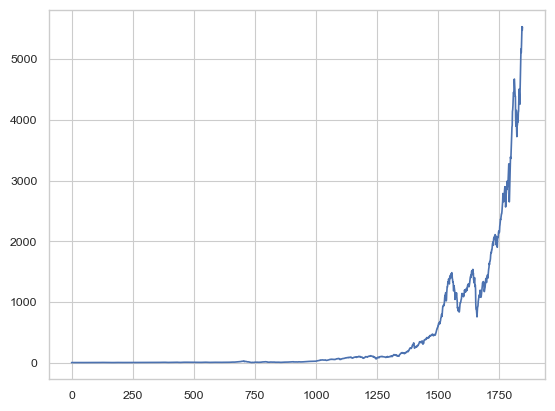

In [15]:
plt.plot(df_spx["Close"].values)

In [16]:
df = df.merge(df_spx.filter(["DATE","SPX_diff"]), how="left", on="DATE")
df

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff
0,1948-01-01,3.4,10.242086,1,NaN,-0.024984
1,1948-02-01,3.8,9.481961,2,NaN,-0.107595
2,1948-03-01,4.0,6.818182,3,NaN,-0.056728
3,1948-04-01,3.9,8.272727,4,NaN,0.054795
4,1948-05-01,3.5,9.384966,5,NaN,0.126220
...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,4,5.33,0.240453
916,2024-05-01,4.0,3.250210,5,5.33,0.262664
917,2024-06-01,4.1,2.975629,6,5.33,0.246186
918,2024-07-01,4.3,2.923566,7,5.33,0.228461


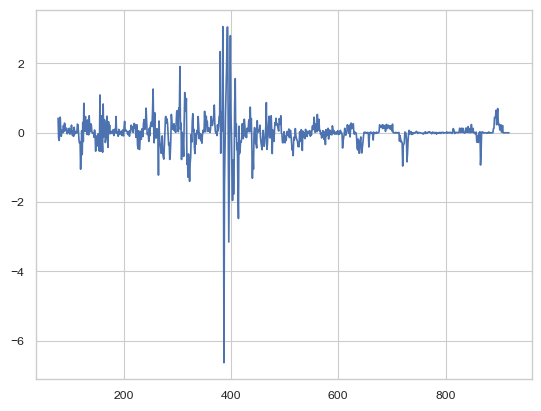

In [17]:
plt.plot(np.diff(df["FEDFUNDS"]))

In [18]:
# calculate next month diff in unemployment rate 
df["FEDFUNDS_diff"] = np.diff(df["FEDFUNDS"], append=np.nan)
df

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff
0,1948-01-01,3.4,10.242086,1,NaN,-0.024984,NaN
1,1948-02-01,3.8,9.481961,2,NaN,-0.107595,NaN
2,1948-03-01,4.0,6.818182,3,NaN,-0.056728,NaN
3,1948-04-01,3.9,8.272727,4,NaN,0.054795,NaN
4,1948-05-01,3.5,9.384966,5,NaN,0.126220,NaN
...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,4,5.33,0.240453,0.0
916,2024-05-01,4.0,3.250210,5,5.33,0.262664,0.0
917,2024-06-01,4.1,2.975629,6,5.33,0.246186,0.0
918,2024-07-01,4.3,2.923566,7,5.33,0.228461,0.0


In [22]:
ff_lower_25 = (df["FEDFUNDS_diff"] < -0.05) & (df["FEDFUNDS_diff"] >= -0.25)
ff_lower_50 = df["FEDFUNDS_diff"] < -0.25 
ff_higher_25 = (df["FEDFUNDS_diff"] > 0.05) & (df["FEDFUNDS_diff"] <= 0.25)
ff_higher_50 = df["FEDFUNDS_diff"] > 0.25
ff_stable = df["FEDFUNDS_diff"].abs() <= 0.05
# add ur to df
df["ff_lower_25"] = ff_lower_25
df["ff_lower_50"] = ff_lower_50
df["ff_higher_25"] = ff_higher_25
df["ff_higher_50"] = ff_higher_50
df["ff_stable"] = ff_stable
df

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,ff_higher_50,ff_stable
0,1948-01-01,3.4,10.242086,1,NaN,-0.024984,NaN,False,False,False,False,False
1,1948-02-01,3.8,9.481961,2,NaN,-0.107595,NaN,False,False,False,False,False
2,1948-03-01,4.0,6.818182,3,NaN,-0.056728,NaN,False,False,False,False,False
3,1948-04-01,3.9,8.272727,4,NaN,0.054795,NaN,False,False,False,False,False
4,1948-05-01,3.5,9.384966,5,NaN,0.126220,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,4,5.33,0.240453,0.0,False,False,False,False,True
916,2024-05-01,4.0,3.250210,5,5.33,0.262664,0.0,False,False,False,False,True
917,2024-06-01,4.1,2.975629,6,5.33,0.246186,0.0,False,False,False,False,True
918,2024-07-01,4.3,2.923566,7,5.33,0.228461,0.0,False,False,False,False,True


In [23]:
# add last 3 month data about unemployment rate, inflation , fedfunds, SPX to df 
# as new columns (i.e: "Total-1", "Total-2", "Total-3")

df["UNRATE-1"] = df["UNRATE"].shift(1)
df["UNRATE-2"] = df["UNRATE"].shift(2)
df["UNRATE-3"] = df["UNRATE"].shift(3)

df["Inflation-1"] = df["Inflation"].shift(1)
df["Inflation-2"] = df["Inflation"].shift(2)
df["Inflation-3"] = df["Inflation"].shift(3)

df["fedfunds-1"] = df["FEDFUNDS"].shift(1)
df["fedfunds-2"] = df["FEDFUNDS"].shift(2)
df["fedfunds-3"] = df["FEDFUNDS"].shift(3)

df["spx-1"] = df["SPX_diff"].shift(1)
df["spx-2"] = df["SPX_diff"].shift(2)
df["spx-3"] = df["SPX_diff"].shift(3)

# diff : the difference between the current value and the previous value
df["UNRATE-1_diff"] = df["UNRATE"] - df["UNRATE-1"]
df["UNRATE-2_diff"] = df["UNRATE-1"] - df["UNRATE-2"]
df["UNRATE-3_diff"] = df["UNRATE-2"] - df["UNRATE-3"] 

df["Inflation-1_diff"] = df["Inflation"] - df["Inflation-1"]
df["Inflation-2_diff"] = df["Inflation-1"] - df["Inflation-2"]
df["Inflation-3_diff"] = df["Inflation-2"] - df["Inflation-3"]

df["fedfunds-1_diff"] = df["FEDFUNDS"] - df["fedfunds-1"]
df["fedfunds-2_diff"] = df["fedfunds-1"] - df["fedfunds-2"]
df["fedfunds-3_diff"] = df["fedfunds-2"] - df["fedfunds-3"]
# 1954-10-01
df

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,...,spx-3,UNRATE-1_diff,UNRATE-2_diff,UNRATE-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff
0,1948-01-01,3.4,10.242086,1,NaN,-0.024984,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1948-02-01,3.8,9.481961,2,NaN,-0.107595,NaN,False,False,False,...,NaN,0.4,NaN,NaN,-0.760125,NaN,NaN,NaN,NaN,NaN
2,1948-03-01,4.0,6.818182,3,NaN,-0.056728,NaN,False,False,False,...,NaN,0.2,0.4,NaN,-2.663779,-0.760125,NaN,NaN,NaN,NaN
3,1948-04-01,3.9,8.272727,4,NaN,0.054795,NaN,False,False,False,...,-0.024984,-0.1,0.2,0.4,1.454545,-2.663779,-0.760125,NaN,NaN,NaN
4,1948-05-01,3.5,9.384966,5,NaN,0.126220,NaN,False,False,False,...,-0.107595,-0.4,-0.1,0.2,1.112239,1.454545,-2.663779,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,4,5.33,0.240453,0.0,False,False,False,...,0.213053,0.1,-0.1,0.2,-0.117400,0.309388,0.059762,0.0,0.0,0.0
916,2024-05-01,4.0,3.250210,5,5.33,0.262664,0.0,False,False,False,...,0.228518,0.1,0.1,-0.1,-0.107521,-0.117400,0.309388,0.0,0.0,0.0
917,2024-06-01,4.1,2.975629,6,5.33,0.246186,0.0,False,False,False,...,0.302883,0.1,0.1,0.1,-0.274582,-0.107521,-0.117400,0.0,0.0,0.0
918,2024-07-01,4.3,2.923566,7,5.33,0.228461,0.0,False,False,False,...,0.240453,0.2,0.1,0.1,-0.052063,-0.274582,-0.107521,0.0,0.0,0.0


In [24]:
df.columns

Index(['DATE', 'UNRATE', 'Inflation', 'num_month', 'FEDFUNDS', 'SPX_diff',
       'FEDFUNDS_diff', 'ff_lower_25', 'ff_lower_50', 'ff_higher_25',
       'ff_higher_50', 'ff_stable', 'UNRATE-1', 'UNRATE-2', 'UNRATE-3',
       'Inflation-1', 'Inflation-2', 'Inflation-3', 'fedfunds-1', 'fedfunds-2',
       'fedfunds-3', 'spx-1', 'spx-2', 'spx-3', 'UNRATE-1_diff',
       'UNRATE-2_diff', 'UNRATE-3_diff', 'Inflation-1_diff',
       'Inflation-2_diff', 'Inflation-3_diff', 'fedfunds-1_diff',
       'fedfunds-2_diff', 'fedfunds-3_diff'],
      dtype='object')

In [25]:
"""list_feat = ['Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'num_month', 'Total-1',
       'Total-2', 'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3',
       'fedfunds-1', 'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3']"""


#df_x = df.filter(list_feat)
#df_x

"list_feat = ['Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'num_month', 'Total-1',\n       'Total-2', 'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3',\n       'fedfunds-1', 'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3']"

In [26]:
df_for_pred = df.iloc[-1:]
df_for_pred

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,...,spx-3,UNRATE-1_diff,UNRATE-2_diff,UNRATE-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff
919,2024-08-01,4.2,2.591227,8,5.33,0.237667,NaN,False,False,False,...,0.262664,-0.1,0.2,0.1,-0.332339,-0.052063,-0.274582,0.0,0.0,0.0


In [27]:
df.dropna(inplace=True)
df

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,...,spx-3,UNRATE-1_diff,UNRATE-2_diff,UNRATE-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff
81,1954-10-01,5.7,-0.853432,10,0.85,0.342511,-0.02,False,False,False,...,0.240428,-0.4,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42
82,1954-11-01,5.3,-0.260708,11,0.83,0.364898,0.45,False,False,False,...,0.259943,-0.4,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15
83,1954-12-01,5.0,-0.372162,12,1.28,0.408377,0.11,False,False,True,...,0.351526,-0.3,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22
84,1955-01-01,4.9,-0.631032,1,1.39,0.398272,-0.10,True,False,False,...,0.342511,-0.1,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02
85,1955-02-01,4.7,-0.629863,2,1.29,0.413912,0.06,False,False,True,...,0.364898,-0.2,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,3,5.33,0.302883,0.00,False,False,False,...,0.197494,-0.1,0.2,0.0,0.309388,0.059762,-0.217179,0.00,0.00,0.00
915,2024-04-01,3.9,3.357731,4,5.33,0.240453,0.00,False,False,False,...,0.213053,0.1,-0.1,0.2,-0.117400,0.309388,0.059762,0.00,0.00,0.00
916,2024-05-01,4.0,3.250210,5,5.33,0.262664,0.00,False,False,False,...,0.228518,0.1,0.1,-0.1,-0.107521,-0.117400,0.309388,0.00,0.00,0.00
917,2024-06-01,4.1,2.975629,6,5.33,0.246186,0.00,False,False,False,...,0.302883,0.1,0.1,0.1,-0.274582,-0.107521,-0.117400,0.00,0.00,0.00


## Target

Creation of a multi-class target : df_y["class"]

In [28]:
df["class"] = 0*df["ff_lower_50"] + 1*df["ff_lower_25"] + 2*df["ff_stable"] + 3*df["ff_higher_25"] + 4*df["ff_higher_50"]
df

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,...,UNRATE-1_diff,UNRATE-2_diff,UNRATE-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class
81,1954-10-01,5.7,-0.853432,10,0.85,0.342511,-0.02,False,False,False,...,-0.4,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42,2
82,1954-11-01,5.3,-0.260708,11,0.83,0.364898,0.45,False,False,False,...,-0.4,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15,4
83,1954-12-01,5.0,-0.372162,12,1.28,0.408377,0.11,False,False,True,...,-0.3,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22,3
84,1955-01-01,4.9,-0.631032,1,1.39,0.398272,-0.10,True,False,False,...,-0.1,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02,1
85,1955-02-01,4.7,-0.629863,2,1.29,0.413912,0.06,False,False,True,...,-0.2,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,3,5.33,0.302883,0.00,False,False,False,...,-0.1,0.2,0.0,0.309388,0.059762,-0.217179,0.00,0.00,0.00,2
915,2024-04-01,3.9,3.357731,4,5.33,0.240453,0.00,False,False,False,...,0.1,-0.1,0.2,-0.117400,0.309388,0.059762,0.00,0.00,0.00,2
916,2024-05-01,4.0,3.250210,5,5.33,0.262664,0.00,False,False,False,...,0.1,0.1,-0.1,-0.107521,-0.117400,0.309388,0.00,0.00,0.00,2
917,2024-06-01,4.1,2.975629,6,5.33,0.246186,0.00,False,False,False,...,0.1,0.1,0.1,-0.274582,-0.107521,-0.117400,0.00,0.00,0.00,2


In [29]:
df_y = df.filter(['FEDFUNDS_diff',
     'ff_lower_50', 'ff_lower_25', 'ff_stable',"ff_higher_25", "ff_higher_50" ,"class"])
df_y

,FEDFUNDS_diff,ff_lower_50,ff_lower_25,ff_stable,ff_higher_25,ff_higher_50,class
81,-0.02,False,False,True,False,False,2
82,0.45,False,False,False,False,True,4
83,0.11,False,False,False,True,False,3
84,-0.10,False,True,False,False,False,1
85,0.06,False,False,False,True,False,3
...,...,...,...,...,...,...,...
914,0.00,False,False,True,False,False,2
915,0.00,False,False,True,False,False,2
916,0.00,False,False,True,False,False,2
917,0.00,False,False,True,False,False,2


In [30]:
list_targets = ['ff_lower_50', 'ff_lower_25', 'ff_stable',"ff_higher_25", "ff_higher_50"]

## Split Train / Test

In [31]:

nb_test = int(df.shape[0] * (1 - ratio_test))
print("nb_test : ", nb_test)
#from sklearn.model_selection import train_test_split
#xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)


nb_test :  823


In [32]:
df_train = df.iloc[:nb_test].copy()
df_test = df.iloc[nb_test:].copy()
df_train

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,...,UNRATE-1_diff,UNRATE-2_diff,UNRATE-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class
81,1954-10-01,5.7,-0.853432,10,0.85,0.342511,-0.02,False,False,False,...,-0.4,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42,2
82,1954-11-01,5.3,-0.260708,11,0.83,0.364898,0.45,False,False,False,...,-0.4,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15,4
83,1954-12-01,5.0,-0.372162,12,1.28,0.408377,0.11,False,False,True,...,-0.3,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22,3
84,1955-01-01,4.9,-0.631032,1,1.39,0.398272,-0.10,True,False,False,...,-0.1,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02,1
85,1955-02-01,4.7,-0.629863,2,1.29,0.413912,0.06,False,False,True,...,-0.2,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,2022-12-01,3.5,6.411498,12,4.10,-0.163086,0.23,False,False,True,...,-0.1,0.0,0.1,-0.707968,-0.632475,-0.446331,0.32,0.70,0.52,3
900,2023-01-01,3.4,6.362123,1,4.33,-0.134059,0.24,False,False,True,...,-0.1,-0.1,0.0,-0.049375,-0.707968,-0.632475,0.23,0.32,0.70,3
901,2023-02-01,3.6,5.965523,2,4.57,-0.080320,0.08,False,False,True,...,0.2,-0.1,-0.1,-0.396601,-0.049375,-0.707968,0.24,0.23,0.32,3
902,2023-03-01,3.5,4.935090,3,4.65,-0.096261,0.18,False,False,True,...,-0.1,0.2,-0.1,-1.030432,-0.396601,-0.049375,0.08,0.24,0.23,3


In [33]:
df_test

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,...,UNRATE-1_diff,UNRATE-2_diff,UNRATE-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class
904,2023-05-01,3.7,4.120690,5,5.06,0.026188,0.02,False,False,False,...,0.3,-0.1,-0.1,-0.820370,0.005969,-1.030432,0.23,0.18,0.08,2
905,2023-06-01,3.6,3.053262,6,5.08,0.114497,0.04,False,False,False,...,-0.1,0.3,-0.1,-1.067428,-0.820370,0.005969,0.02,0.23,0.18,2
906,2023-07-01,3.5,3.271781,7,5.12,0.152452,0.21,False,False,True,...,-0.1,-0.1,0.3,0.218519,-1.067428,-0.820370,0.04,0.02,0.23,3
907,2023-08-01,3.8,3.718721,8,5.33,0.064368,0.00,False,False,False,...,0.3,-0.1,-0.1,0.446941,0.218519,-1.067428,0.21,0.04,0.02,2
908,2023-09-01,3.8,3.694055,9,5.33,0.145066,0.00,False,False,False,...,0.0,0.3,-0.1,-0.024666,0.446941,0.218519,0.00,0.21,0.04,2
909,2023-10-01,3.8,3.245787,10,5.33,0.143028,0.00,False,False,False,...,0.0,0.0,0.3,-0.448268,-0.024666,0.446941,0.00,0.00,0.21,2
910,2023-11-01,3.7,3.139482,11,5.33,0.138499,0.00,False,False,False,...,-0.1,0.0,0.0,-0.106306,-0.448268,-0.024666,0.00,0.00,0.00,2
911,2023-12-01,3.7,3.323160,12,5.33,0.197494,0.00,False,False,False,...,0.0,-0.1,0.0,0.183678,-0.106306,-0.448268,0.00,0.00,0.00,2
912,2024-01-01,3.7,3.105981,1,5.33,0.213053,0.00,False,False,False,...,0.0,0.0,-0.1,-0.217179,0.183678,-0.106306,0.00,0.00,0.00,2
913,2024-02-01,3.9,3.165743,2,5.33,0.228518,0.00,False,False,False,...,0.2,0.0,0.0,0.059762,-0.217179,0.183678,0.00,0.00,0.00,2


In [34]:
df_train["TRAIN"] = 1
df_test["TRAIN"] = 0
df = pd.concat([df_train, df_test], axis=0)
df

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,...,UNRATE-2_diff,UNRATE-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class,TRAIN
81,1954-10-01,5.7,-0.853432,10,0.85,0.342511,-0.02,False,False,False,...,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42,2,1
82,1954-11-01,5.3,-0.260708,11,0.83,0.364898,0.45,False,False,False,...,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15,4,1
83,1954-12-01,5.0,-0.372162,12,1.28,0.408377,0.11,False,False,True,...,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22,3,1
84,1955-01-01,4.9,-0.631032,1,1.39,0.398272,-0.10,True,False,False,...,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02,1,1
85,1955-02-01,4.7,-0.629863,2,1.29,0.413912,0.06,False,False,True,...,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,3,5.33,0.302883,0.00,False,False,False,...,0.2,0.0,0.309388,0.059762,-0.217179,0.00,0.00,0.00,2,0
915,2024-04-01,3.9,3.357731,4,5.33,0.240453,0.00,False,False,False,...,-0.1,0.2,-0.117400,0.309388,0.059762,0.00,0.00,0.00,2,0
916,2024-05-01,4.0,3.250210,5,5.33,0.262664,0.00,False,False,False,...,0.1,-0.1,-0.107521,-0.117400,0.309388,0.00,0.00,0.00,2,0
917,2024-06-01,4.1,2.975629,6,5.33,0.246186,0.00,False,False,False,...,0.1,0.1,-0.274582,-0.107521,-0.117400,0.00,0.00,0.00,2,0


### Select Features

In [35]:
list_feat = ['UNRATE', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'num_month', 
       'UNRATE-1_diff', 'UNRATE-2_diff', 'UNRATE-3_diff',
       'Inflation-1_diff', 'Inflation-2_diff', 'Inflation-3_diff',
       'fedfunds-1_diff', 'fedfunds-2_diff', 'fedfunds-3_diff', 
       'spx-1', 'spx-2', 'spx-3']

### Check features repart

#### Check Out of range
check if Test out of Train range for each features

In [223]:
df_min = df.filter(list_feat).groupby(df["TRAIN"]).min().transpose()
df_min["feat"] = df_min.index
df_min["out_min"] = df_min[0] < df_min[1]
df_min["pc_out_min"] = df_min["feat"].apply(
    lambda x: 100*sum(df[df["TRAIN"] == 0 ][x] <  df[df["TRAIN"] == 1][x].min()) / df[df["TRAIN"] == 0 ].shape[0]
    )
assert df_min["pc_out_min"].max() < 5, "Some TEST features are not in Train !"
df_max = df.filter(list_feat).groupby(df["TRAIN"]).max().transpose()
df_max["feat"] = df_max.index
df_max["out_max"] = df_max[0] > df_max[1]
df_max["pc_out_max"] = df_max["feat"].apply(
    lambda x: 100*sum(df[df["TRAIN"] == 0 ][x] >  df[df["TRAIN"] == 1][x].max()) / df[df["TRAIN"] == 0 ].shape[0]
    )
assert df_max["pc_out_max"].max() < 5 , "Some TEST features are not in Train !"
df_range = df_min.copy()
df_range.drop(columns=["feat", "out_min"], inplace=True)
df_range.rename_axis(columns=None, inplace=True)
df_range.rename_axis(index="Features", inplace=True)
df_range.rename(columns={0: "min TEST", 1: "min TRAIN"}, inplace=True)
df_range_max = df_max.copy()
df_range_max.drop(columns=["feat", "out_max"], inplace=True)
df_range_max.rename_axis(columns=None, inplace=True)
df_range_max.rename_axis(index="Features", inplace=True)
df_range_max.rename(columns={0: "max TEST", 1: "max TRAIN"}, inplace=True)
df_range = df_range.join(df_range_max)
df_range

,min TEST,min TRAIN,pc_out_min,max TEST,max TRAIN,pc_out_max
Features,,,,,,
UNRATE,3.500000,3.400000,0.0,4.300000,14.800000,0.0
Inflation,2.923566,-1.958761,0.0,4.120690,14.592275,0.0
FEDFUNDS,5.060000,0.050000,0.0,5.330000,19.100000,0.0
SPX_diff,0.026188,-0.425084,0.0,0.302883,0.526508,0.0
num_month,1.000000,1.000000,0.0,12.000000,12.000000,0.0
UNRATE-1_diff,-0.100000,-2.200000,0.0,0.300000,10.400000,0.0
UNRATE-2_diff,-0.100000,-2.200000,0.0,0.300000,10.400000,0.0
UNRATE-3_diff,-0.100000,-2.200000,0.0,0.300000,10.400000,0.0
Inflation-1_diff,-1.067428,-2.631140,0.0,0.446941,2.138555,0.0


### Check repart target

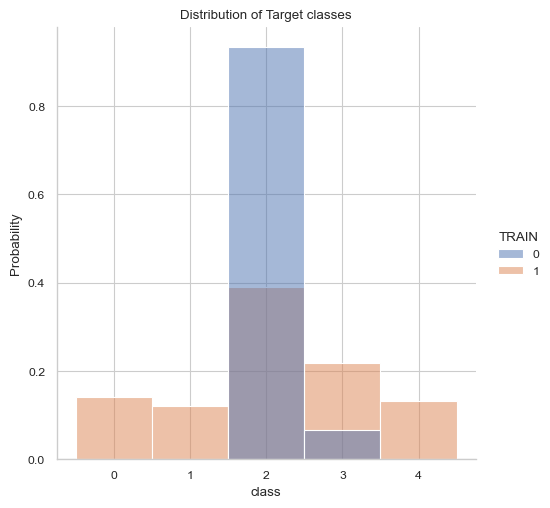

In [41]:
g = sns.displot(
    df,
    x="class",
    hue="TRAIN",
    stat="probability",
    common_norm=False,
    discrete=True,
)

plt.gca().set_title("Distribution of Target classes")
plt.show()

In [42]:
def print_repart(df_train, df_test, str_target):
    print("\nRepart for ", str_target, ":")
    print("- on TRAIN :\n",
        "  - proba:\n",
        df_train[str_target].value_counts() / df_train.shape[0],
        "\n  - nb: ", 
        df_train[str_target].shape[0]*(df_train[str_target].value_counts() / df_train.shape[0]).values,
    )
    print("- on TEST :\n", 
        "  - proba:\n",
        df_test[str_target].value_counts() / df_test.shape[0],
        "\n  - nb: ", 
        df_test[str_target].shape[0]*(df_test[str_target].value_counts() / df_test.shape[0]).values,)

for str_target in list_targets:
    print_repart(df_train, df_test, str_target)

print("end")


Repart for  ff_lower_50 :
- on TRAIN :
   - proba:
 False    0.859052
True     0.140948
Name: ff_lower_50, dtype: float64 
  - nb:  [707. 116.]
- on TEST :
   - proba:
 False    1.0
Name: ff_lower_50, dtype: float64 
  - nb:  [15.]

Repart for  ff_lower_25 :
- on TRAIN :
   - proba:
 False    0.879708
True     0.120292
Name: ff_lower_25, dtype: float64 
  - nb:  [724.  99.]
- on TEST :
   - proba:
 False    1.0
Name: ff_lower_25, dtype: float64 
  - nb:  [15.]

Repart for  ff_stable :
- on TRAIN :
   - proba:
 False    0.609964
True     0.390036
Name: ff_stable, dtype: float64 
  - nb:  [502. 321.]
- on TEST :
   - proba:
 True     0.933333
False    0.066667
Name: ff_stable, dtype: float64 
  - nb:  [14.  1.]

Repart for  ff_higher_25 :
- on TRAIN :
   - proba:
 False    0.782503
True     0.217497
Name: ff_higher_25, dtype: float64 
  - nb:  [644. 179.]
- on TEST :
   - proba:
 False    0.933333
True     0.066667
Name: ff_higher_25, dtype: float64 
  - nb:  [14.  1.]

Repart for  ff_h

<Axes: xlabel='DATE', ylabel='FEDFUNDS'>

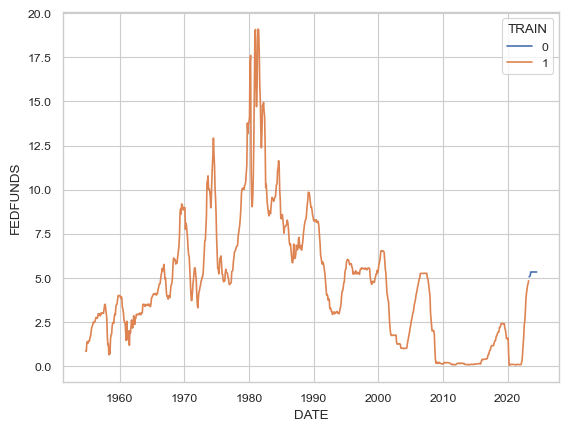

In [43]:
sns.lineplot(data=df.dropna(), x="DATE", y="FEDFUNDS", hue="TRAIN")

<Axes: xlabel='DATE', ylabel='FEDFUNDS_diff'>

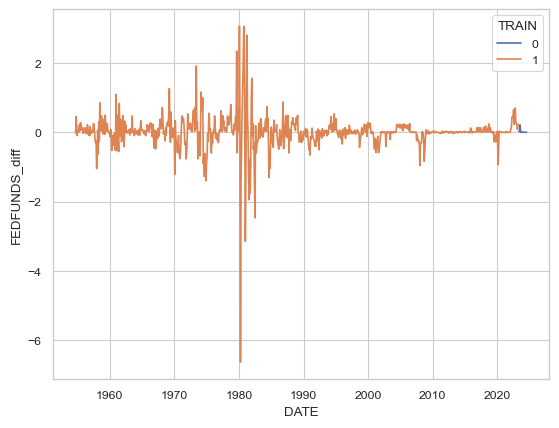

In [44]:
sns.lineplot(data=df.dropna(), x="DATE", y="FEDFUNDS_diff", hue="TRAIN")

<Axes: xlabel='DATE', ylabel='class'>

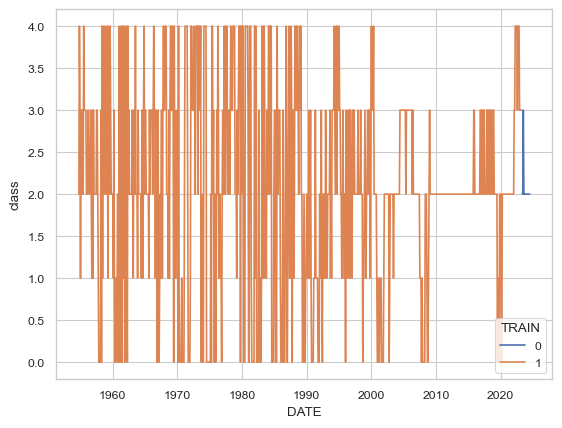

In [45]:
sns.lineplot(data=df.dropna(), x="DATE", y="class", hue="TRAIN")

## Scale

In [46]:
df

,DATE,UNRATE,Inflation,num_month,FEDFUNDS,SPX_diff,FEDFUNDS_diff,ff_lower_25,ff_lower_50,ff_higher_25,...,UNRATE-2_diff,UNRATE-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class,TRAIN
81,1954-10-01,5.7,-0.853432,10,0.85,0.342511,-0.02,False,False,False,...,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42,2,1
82,1954-11-01,5.3,-0.260708,11,0.83,0.364898,0.45,False,False,False,...,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15,4,1
83,1954-12-01,5.0,-0.372162,12,1.28,0.408377,0.11,False,False,True,...,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22,3,1
84,1955-01-01,4.9,-0.631032,1,1.39,0.398272,-0.10,True,False,False,...,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02,1,1
85,1955-02-01,4.7,-0.629863,2,1.29,0.413912,0.06,False,False,True,...,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,3,5.33,0.302883,0.00,False,False,False,...,0.2,0.0,0.309388,0.059762,-0.217179,0.00,0.00,0.00,2,0
915,2024-04-01,3.9,3.357731,4,5.33,0.240453,0.00,False,False,False,...,-0.1,0.2,-0.117400,0.309388,0.059762,0.00,0.00,0.00,2,0
916,2024-05-01,4.0,3.250210,5,5.33,0.262664,0.00,False,False,False,...,0.1,-0.1,-0.107521,-0.117400,0.309388,0.00,0.00,0.00,2,0
917,2024-06-01,4.1,2.975629,6,5.33,0.246186,0.00,False,False,False,...,0.1,0.1,-0.274582,-0.107521,-0.117400,0.00,0.00,0.00,2,0


In [47]:
# feat on train
xtrain = df[df["TRAIN"] == 1][list_feat].values
# feat on test
xtest = df[df["TRAIN"] == 0][list_feat].values 
# target on train
ytrain = df[df["TRAIN"] == 1]["class"].values
# target on test
ytest = df[df["TRAIN"] == 0]["class"].values

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(xtrain)
X_test = scaler.transform(xtest)

# for last pred : (to predict next month value)
x_for_pred = df_for_pred.filter(list_feat).iloc[-1].values.reshape(1, -1)
X_for_pred = scaler.transform(x_for_pred)
X_for_pred

array([[-1.00290089, -0.35965725,  0.20002009,  0.94215697,  0.43433528,
        -0.22650564,  0.47548912,  0.24042241, -0.89257936, -0.15294263,
        -0.74473277, -0.00932664, -0.00850823, -0.00934766,  0.88019467,
         0.98878507,  1.08986795]])

In [49]:
#scaler_y = StandardScaler()

#Y = scaler_y.fit_transform(ytrain.reshape(-1, 1))
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

## Correlations

### On Target CLass

In [50]:
df_y

,FEDFUNDS_diff,ff_lower_50,ff_lower_25,ff_stable,ff_higher_25,ff_higher_50,class
81,-0.02,False,False,True,False,False,2
82,0.45,False,False,False,False,True,4
83,0.11,False,False,False,True,False,3
84,-0.10,False,True,False,False,False,1
85,0.06,False,False,False,True,False,3
...,...,...,...,...,...,...,...
914,0.00,False,False,True,False,False,2
915,0.00,False,False,True,False,False,2
916,0.00,False,False,True,False,False,2
917,0.00,False,False,True,False,False,2


In [51]:
list_targets

['ff_lower_50', 'ff_lower_25', 'ff_stable', 'ff_higher_25', 'ff_higher_50']

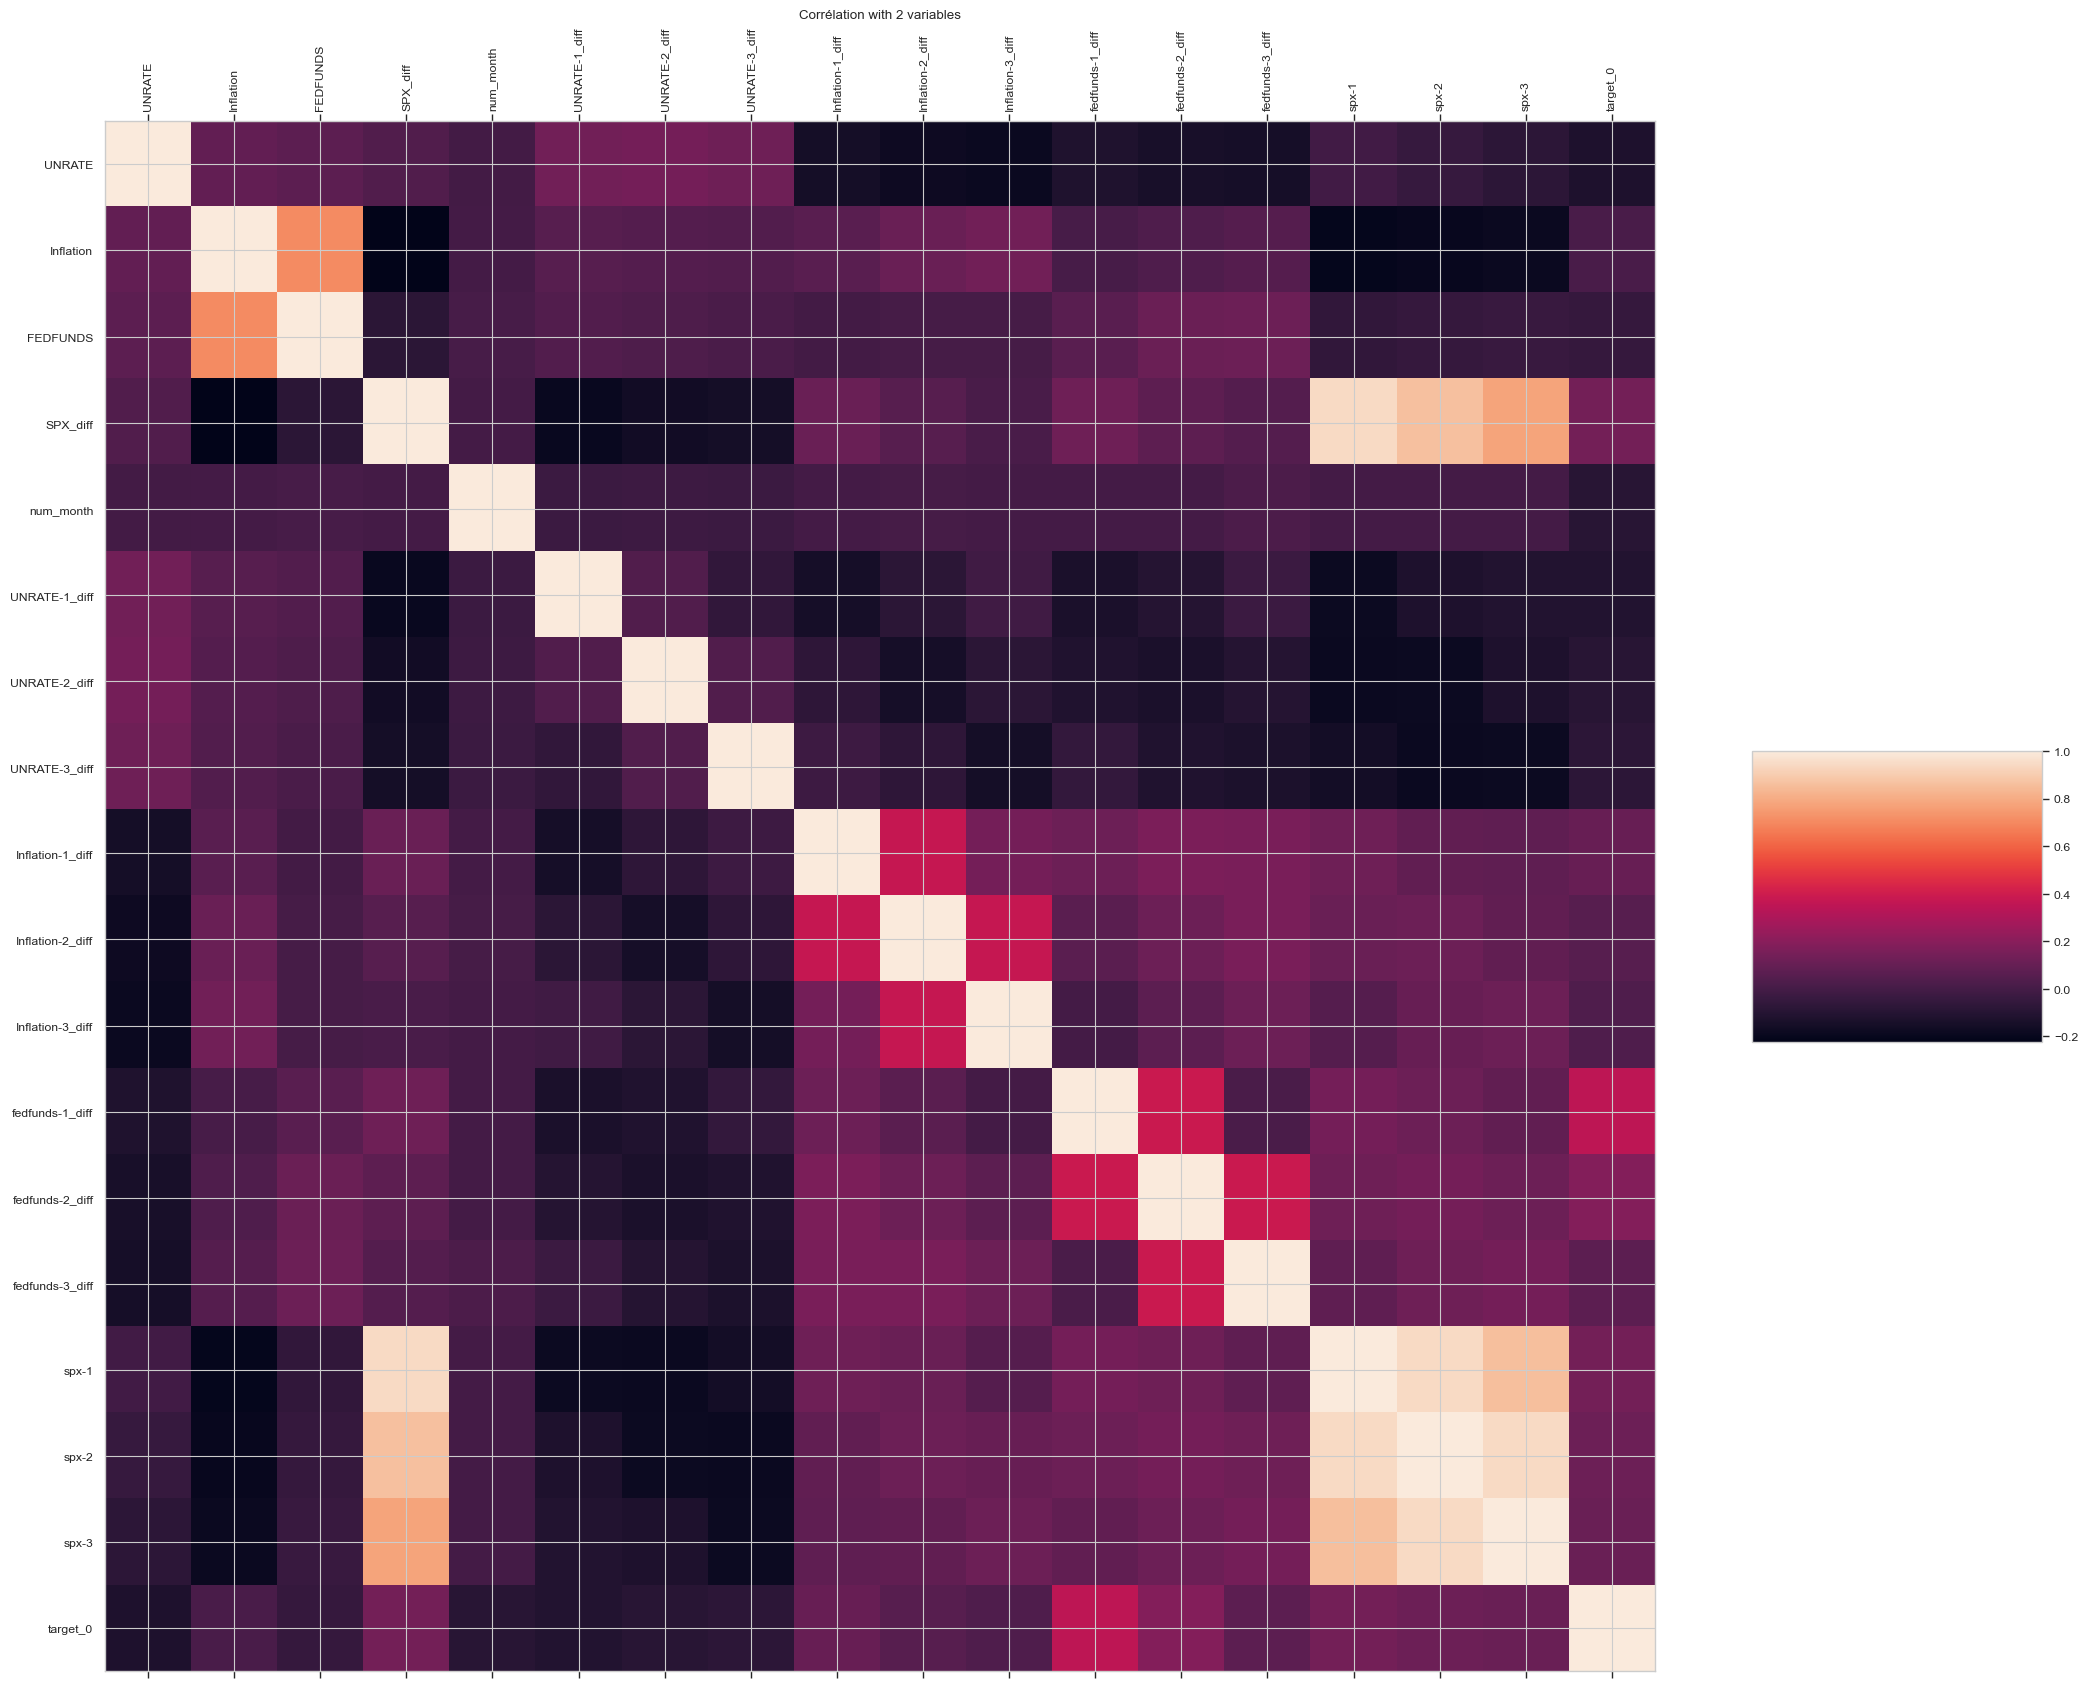

In [52]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=1, size=25):
    """
    Plot heatmap of correlations of all inputs between them
    """
    fig_size = (size, size*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im, aspect=1/aspect, orientation='vertical', location="right")
    plt.show()
nb_plot = len(list_feat)
list_col_targets = [ f"target_{n_t}" for n_t in range(len(["class"]))]
list_col_corr = list_feat[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y


df_for_corr = pd.DataFrame(np.hstack((X, Y)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()

fig = plot_corr(corr_matrix)


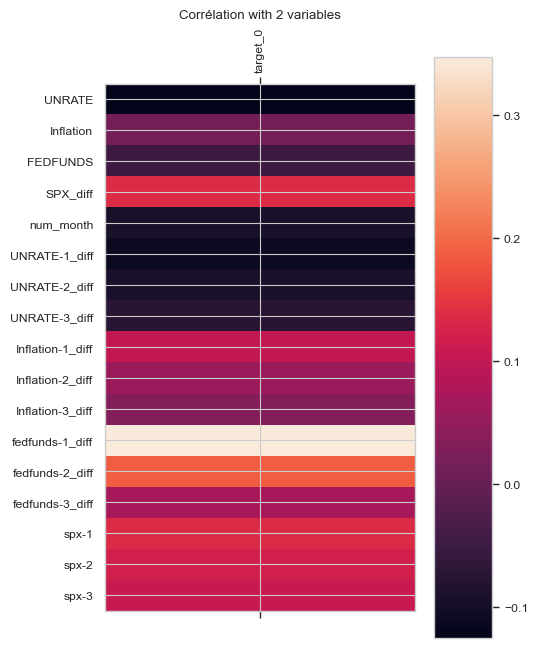

In [53]:
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

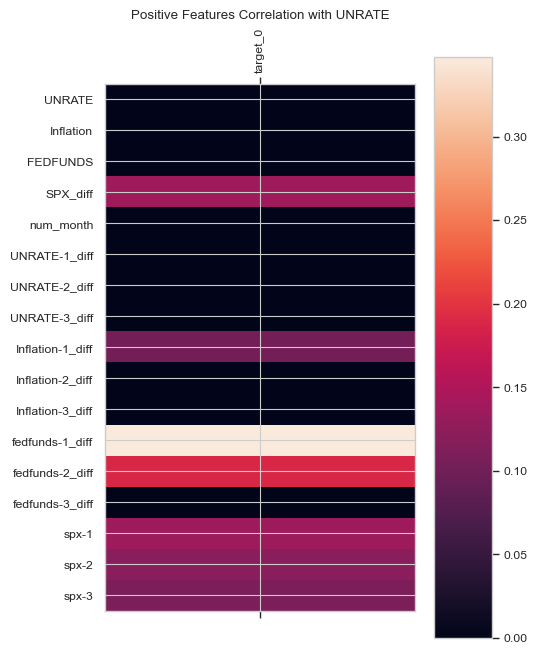

In [54]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets>0.1, 0),
    aspect=0.1, 
    size=5,
    title="Positive Features Correlation with UNRATE"
    )

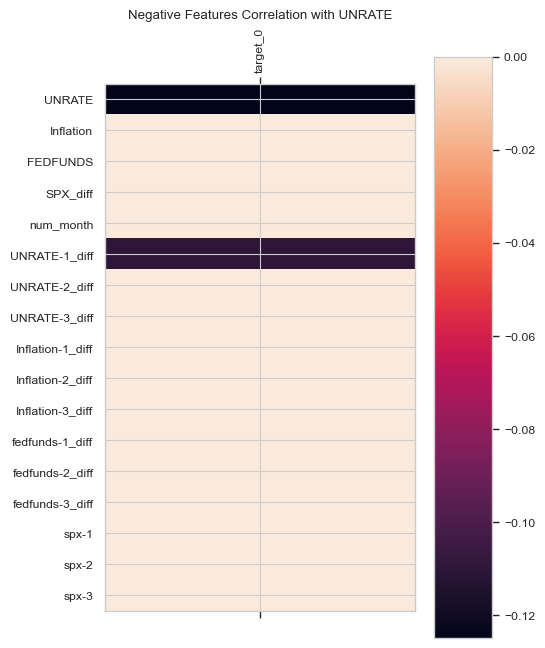

In [55]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets < -0.1, 0),
    aspect=0.1, 
    size=5,
    title="Negative Features Correlation with UNRATE"
    )

In [56]:
corr_matrix_targets.where(corr_matrix_targets < -0.1, 0)

,target_0
UNRATE,-0.124944
Inflation,0.000000
FEDFUNDS,0.000000
SPX_diff,0.000000
num_month,0.000000
UNRATE-1_diff,-0.109565
UNRATE-2_diff,0.000000
UNRATE-3_diff,0.000000
Inflation-1_diff,0.000000
Inflation-2_diff,0.000000


### on FEDFUNDS_diff

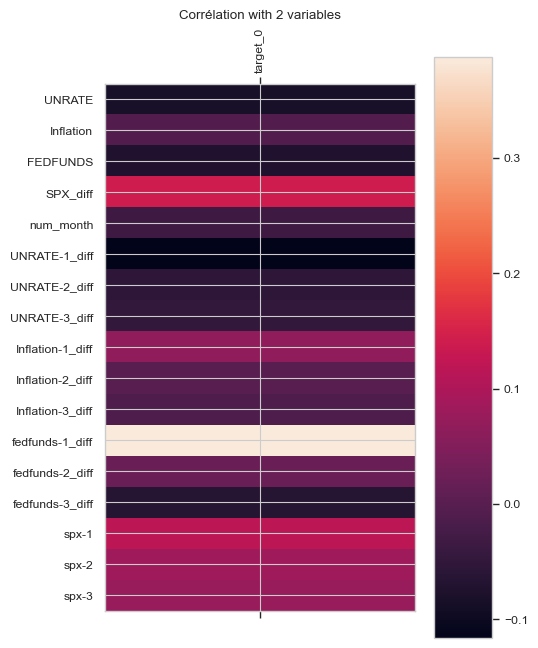

In [57]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["FEDFUNDS_diff"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

### On ff_lower_50

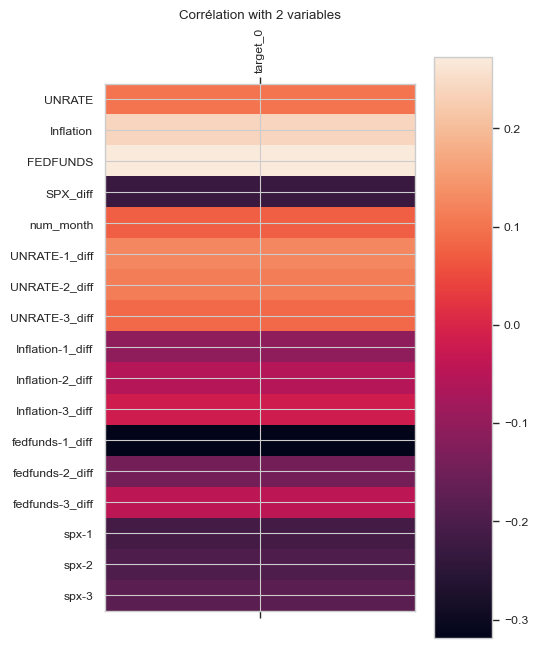

In [58]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["ff_lower_50"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

### On ff_lower_25

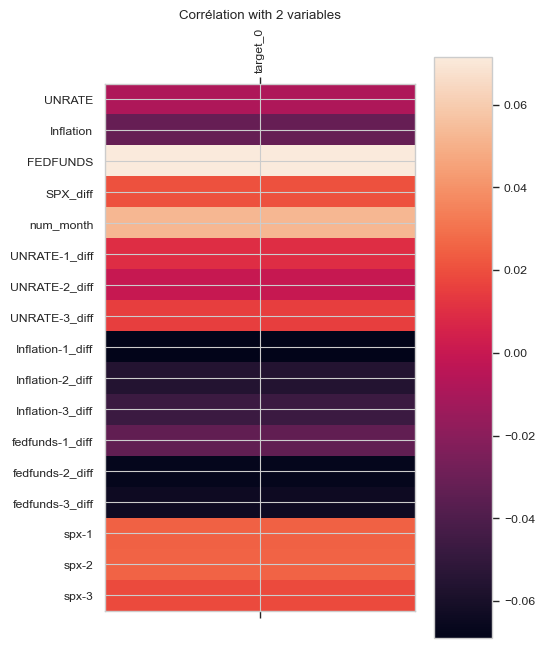

In [59]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["ff_lower_25"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

### On ff_stable

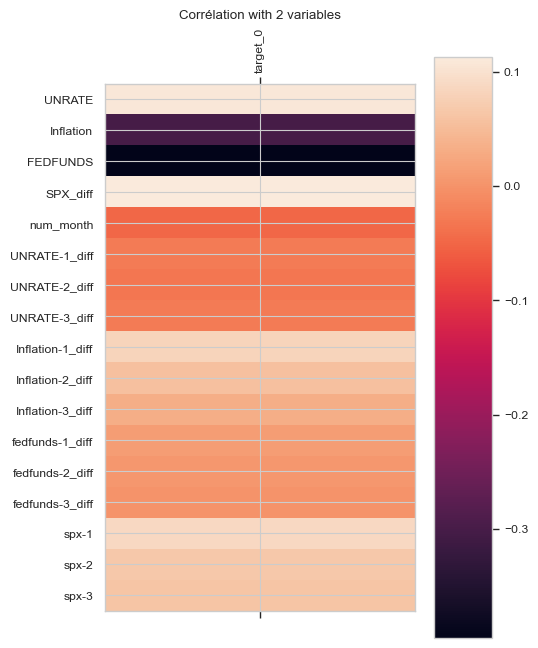

In [60]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["ff_stable"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

### On ff_higher_25

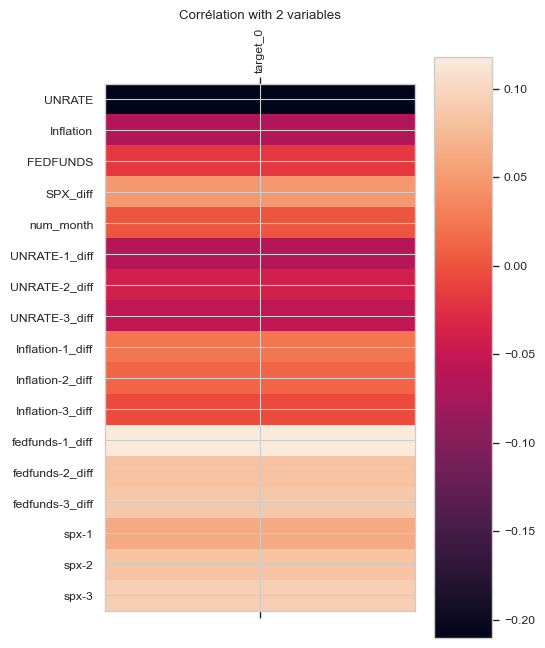

In [61]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["ff_higher_25"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

### On ff_higher_50

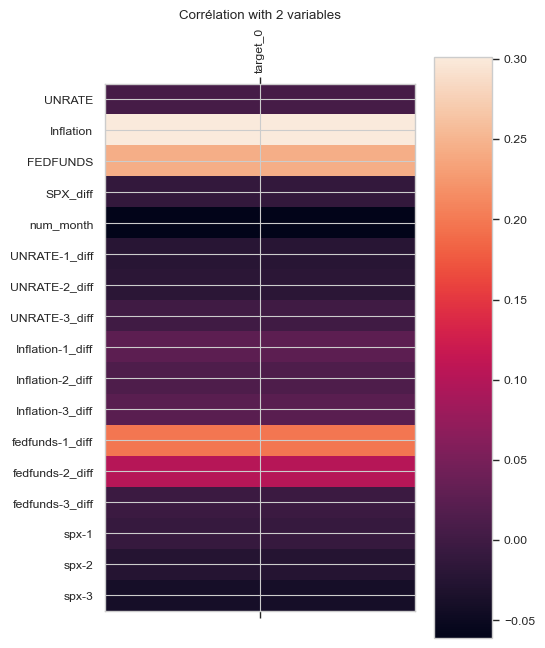

In [62]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["ff_higher_50"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

## Train

### Test some models

In [63]:
X.shape

(823, 17)

In [64]:
Y.shape

(823, 1)

In [65]:
X_test.shape

(15, 17)

In [66]:
Y_test.shape

(15, 1)

In [67]:
X_for_pred.shape

(1, 17)

In [68]:
from sklearn.base import clone
def choose_target(df_y, target, nb_test):
    print("\nTarget : ", target)
    arr_target = df_y[target].values
    ytrain = arr_target[:nb_test]
    ytest = arr_target[nb_test:]
    Y = ytrain.reshape(-1, 1)
    Y_test = ytest.reshape(-1, 1)
    return Y, Y_test


def fit_clf(clf, X, Y, X_test, Y_test, X_for_pred):
    clf.fit(X, Y)
    print("TRAIN score :", clf.score(X, Y))
    print("TEST score :", clf.score(X_test, Y_test))
    print("Next month : ", 
      clf.predict(X_for_pred),
      np.max(clf.predict_proba(X_for_pred)[0]),
    )
    return clf
    
def multi_target_fit(clf, df_y, nb_test, list_targets):
    list_clf = []
    for target in list_targets:
        Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
        new_clf = fit_clf(clone(clf), X, Y, X_test, Y_test, X_for_pred)
        list_clf.append(new_clf)
    return list_clf

In [69]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ff_lower_50
TRAIN score : 0.8493317132442284
TEST score : 1.0
Next month :  [False] 0.9081770317324858

Target :  ff_lower_25
TRAIN score : 0.8760631834750912
TEST score : 0.9333333333333333
Next month :  [False] 0.5055047790068529

Target :  ff_stable
TRAIN score : 0.6549210206561361
TEST score : 0.4666666666666667
Next month :  [False] 0.5441765966361798

Target :  ff_higher_25
TRAIN score : 0.7885783718104495
TEST score : 0.8666666666666667
Next month :  [False] 0.914492320046412

Target :  ff_higher_50
TRAIN score : 0.8420413122721749
TEST score : 0.8666666666666667
Next month :  [False] 0.9935695742437043


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversio

In [71]:
df_y

,FEDFUNDS_diff,ff_lower_50,ff_lower_25,ff_stable,ff_higher_25,ff_higher_50,class
81,-0.02,False,False,True,False,False,2
82,0.45,False,False,False,False,True,4
83,0.11,False,False,False,True,False,3
84,-0.10,False,True,False,False,False,1
85,0.06,False,False,False,True,False,3
...,...,...,...,...,...,...,...
914,0.00,False,False,True,False,False,2
915,0.00,False,False,True,False,False,2
916,0.00,False,False,True,False,False,2
917,0.00,False,False,True,False,False,2


In [87]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.4848116646415553
TEST score : 0.4666666666666667
Next month :  [1] 0.5330985242046086


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])

"""clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))"""


Target :  class
TRAIN score : 0.4422843256379101
TEST score : 0.06666666666666667
Next month :  [3] 0.5762329089316995


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'clf.fit(X, Y)\nprint("TRAIN score :", clf.score(X, Y))\nprint("TEST score :", clf.score(X_test, Y_test))\nprint("Next month : ", clf.predict(X_for_pred))\nprint("classes : ", clf.classes_)\nprint("classes prob : ", clf.predict_proba(X_for_pred))'

##### DecisionTree model : fine tuned

In [184]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(
    random_state=2,
    max_features=6,
    min_samples_leaf=2,
)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.8784933171324423
TEST score : 0.8
Next month :  [2] 1.0


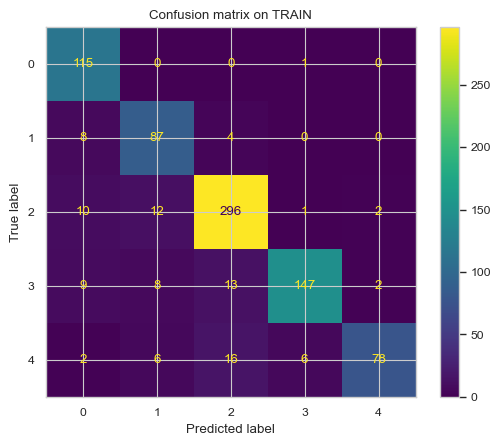

In [186]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = list_clf[0].predict(X)
cm = confusion_matrix(Y, predictions, labels=list_clf[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list_clf[0].classes_)
disp.plot()
plt.title("Confusion matrix on TRAIN")
plt.show()

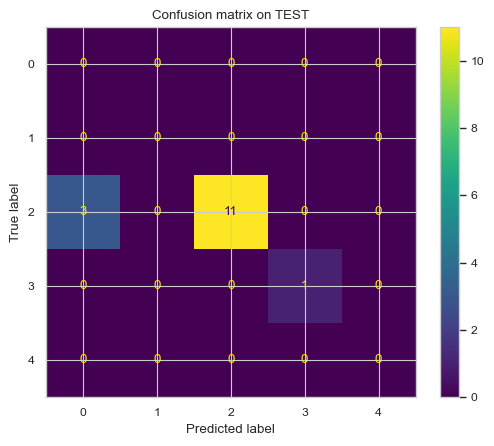

In [185]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = list_clf[0].predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=list_clf[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list_clf[0].classes_)
disp.plot()
plt.title("Confusion matrix on TEST")
plt.show()

In [187]:
list_clf[-1].max_features_

6

In [188]:
list_clf[-1].feature_importances_

array([0.08125057, 0.10392983, 0.13766819, 0.06201539, 0.00736324,
       0.03315812, 0.03482648, 0.03015178, 0.06289023, 0.05878835,
       0.02835062, 0.12733259, 0.08470274, 0.02417126, 0.04243297,
       0.0388793 , 0.04208833])

In [197]:
pd.DataFrame(
    index=list_feat,
    data=list_clf[-1].feature_importances_,
    columns=["Importance"]).sort_values(
        by="Importance", 
        ascending=False,
    )

,Importance
FEDFUNDS,0.137668
fedfunds-1_diff,0.127333
Inflation,0.103930
fedfunds-2_diff,0.084703
UNRATE,0.081251
Inflation-1_diff,0.062890
SPX_diff,0.062015
Inflation-2_diff,0.058788
spx-1,0.042433
spx-3,0.042088


In [71]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability=True)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6114649681528662
TEST score : 0.5761904761904761
Next month :  [2] 0.4053825271895583


In [72]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(random_state=0, loss="log_loss")
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.3248407643312102
TEST score : 0.2
Next month :  [3] 0.5805170280191708


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ff_lower_50
TRAIN score : 0.9171974522292994
TEST score : 0.9095238095238095


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Next month :  [False] 1.0

Target :  ff_lower_25
TRAIN score : 0.8773885350318471


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


TEST score : 0.9142857142857143
Next month :  [False] 1.0

Target :  ff_stable
TRAIN score : 0.8184713375796179
TEST score : 0.49523809523809526
Next month :  [ True] 0.6666666666666666

Target :  ff_higher_25
TRAIN score : 0.8280254777070064
TEST score : 0.680952380952381
Next month :  [False] 0.6666666666666666

Target :  ff_higher_50


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


TRAIN score : 0.8789808917197452
TEST score : 0.9476190476190476
Next month :  [False] 1.0


Multi-class : 

In [96]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets=["class"])


Target :  class
TRAIN score : 0.6114649681528662
TEST score : 0.38095238095238093
Next month :  [2] 0.6666666666666666


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [74]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets=["class"])


Target :  class
TRAIN score : 0.5573248407643312
TEST score : 0.4523809523809524
Next month :  [2] 0.4


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### GradienBoost

one-by-one class :

In [75]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=2)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ff_lower_50


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9777070063694268
TEST score : 0.9380952380952381
Next month :  [False] 0.9807474684045564

Target :  ff_lower_25


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9538216560509554
TEST score : 0.9142857142857143
Next month :  [False] 0.928844466375127

Target :  ff_stable


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9378980891719745
TEST score : 0.4714285714285714
Next month :  [False] 0.8439643475610926

Target :  ff_higher_25


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9299363057324841
TEST score : 0.8476190476190476
Next month :  [False] 0.6687286546221147

Target :  ff_higher_50


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9697452229299363
TEST score : 0.37142857142857144
Next month :  [False] 0.9837382304889356


All classes : method argmax of one by one prob

In [76]:
arr_proba_train = np.zeros((nb_test, len(list_targets)))
arr_proba_test = np.zeros((df_y.shape[0]-nb_test, len(list_targets)))
# loop over clf
for i_clf, target in enumerate(list_targets):
    clf_curr =  list_clf[i_clf]
    Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
    arr_proba_train[:,i_clf] = clf_curr.predict_proba(X)[:, np.argmax(clf_curr.classes_ == True)]
    arr_proba_test[:,i_clf] = clf_curr.predict_proba(X_test)[:, np.argmax(clf_curr.classes_ == True)]
# final accuracy
Y_pred = np.argmax(arr_proba_train, axis=1)
Y_test_pred = np.argmax(arr_proba_test, axis=1)
Y_multi = df_y.iloc[:nb_test]["class"].values
Y_multi_test = df_y.iloc[nb_test:]["class"].values

from sklearn.metrics import accuracy_score
print("Accuracy train : ", accuracy_score(Y_multi, Y_pred))
print("Accuracy test : ", accuracy_score(Y_multi_test, Y_test_pred))


Target :  ff_lower_50

Target :  ff_lower_25

Target :  ff_stable

Target :  ff_higher_25

Target :  ff_higher_50
Accuracy train :  0.9585987261146497
Accuracy test :  0.2523809523809524


Only first and second class : ur_lower and ur_stable :  

In [77]:
list_targets_red = list_targets[:2]
print(list_targets_red)
arr_proba_train = np.zeros((nb_test, len(list_targets_red)))
arr_proba_test = np.zeros((df_y.shape[0]-nb_test, len(list_targets_red)))
# loop over clf
for i_clf, target in enumerate(list_targets_red):
    clf_curr =  list_clf[i_clf]
    Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
    arr_proba_train[:,i_clf] = clf_curr.predict_proba(X)[:, np.argmax(clf_curr.classes_ == True)]
    arr_proba_test[:,i_clf] = clf_curr.predict_proba(X_test)[:, np.argmax(clf_curr.classes_ == True)]
# prediction , last class if other pred < 0.5
Y_pred = np.argmax(arr_proba_train, axis=1)
Y_pred[np.all(arr_proba_train < 0.5, axis=1)] = 2

Y_test_pred = np.argmax(arr_proba_test, axis=1)
Y_test_pred[np.all(arr_proba_test < 0.5, axis=1)] = 2

Y_multi = df_y.iloc[:nb_test]["class"].values
Y_multi_test = df_y.iloc[nb_test:]["class"].values
# final accuracy
from sklearn.metrics import accuracy_score
print("Accuracy train : ", accuracy_score(Y_multi, Y_pred))
print("Accuracy test : ", accuracy_score(Y_multi_test, Y_test_pred))

['ff_lower_50', 'ff_lower_25']

Target :  ff_lower_50

Target :  ff_lower_25
Accuracy train :  0.5270700636942676
Accuracy test :  0.6952380952380952


Multi-class : 

In [78]:
Y, Y_test = choose_target(df_y, target="class", nb_test=nb_test)
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))


Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9777070063694268
TEST score : 0.23809523809523808


In [79]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=1)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)


Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9777070063694268
TEST score : 0.22857142857142856
Next month :  [3] 0.5902646112997721


In [80]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=2)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)


Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9808917197452229
TEST score : 0.2
Next month :  [3] 0.5876121000404897


### MCP

Multi-class

In [81]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6576433121019108
TEST score : 0.5761904761904761
Next month :  [2] 0.6357002246953709
nb iteration :  200


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [82]:
clf = MLPClassifier(random_state=0, 
                    max_iter=1000,
                    n_iter_no_change=1000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Target :  class
TRAIN score : 0.9585987261146497
TEST score : 0.48095238095238096
Next month :  [2] 0.8146730931229321
nb iteration :  1000


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [83]:
clf = MLPClassifier(random_state=0, 
                    max_iter=1500,
                    n_iter_no_change=1500)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Target :  class
TRAIN score : 0.9968152866242038
TEST score : 0.44761904761904764
Next month :  [2] 0.819490300434549
nb iteration :  1500


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [84]:
clf = MLPClassifier(hidden_layer_sizes=(4),
                    random_state=0, 
                    max_iter=48000,
                    n_iter_no_change=48000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Target :  class
TRAIN score : 0.46656050955414013
TEST score : 0.5285714285714286
Next month :  [2] 0.40137865980310766
nb iteration :  48000


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [85]:
clf = MLPClassifier(hidden_layer_sizes=(8),
                    random_state=4, 
                    max_iter=40000,
                    n_iter_no_change=40000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Target :  class
TRAIN score : 0.5429936305732485
TEST score : 0.44761904761904764
Next month :  [2] 0.5482002029965664
nb iteration :  40000


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40000) reached and the optimization hasn't converged yet.
  warnings.warn(


#### MLP CV Alpha

In [86]:
from sklearn.neural_network import MLPClassifier
list_nb_iter = [1000, 2000, 4000]
list_random_state = [0, 1, 2, 3, 4]
list_nb_cell = [8, 16, 32]
list_alpha = [0.0001, 0.0005, 0.001, 0.01]
df_res_alpha = pd.DataFrame(
    columns=[
        "nb_neurons",
        "nb_iter",
        "random_state",
        "alpha",
        "accuracy",
        "accuracy_test",
    ]
)

Y, Y_test = choose_target(df_y, "class", nb_test)

acc_best = 0
for nb_neurons in list_nb_cell:
    for nb_iter in list_nb_iter:
        for random_state in list_random_state:
            for alpha in list_alpha:
                param = (nb_neurons, nb_iter, random_state, alpha)
                print(f"\nnb_neurons: {nb_neurons} , nb_iter: {nb_iter}, random_state: {random_state}, alpha: {alpha}")
                clf = MLPClassifier(
                    hidden_layer_sizes=(nb_neurons),
                    random_state=random_state, 
                    max_iter=nb_iter,
                    n_iter_no_change=nb_iter,
                    alpha=alpha,
                )
                list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
                acc_curr = list_clf[0].score(X, Y)
                acc_curr_test = list_clf[0].score(X_test, Y_test)
                df_res_alpha = df_res_alpha.append(
                    {
                        "nb_neurons": nb_neurons, 
                        "nb_iter": nb_iter, 
                        "random_state": random_state, 
                        "alpha": alpha,
                        "accuracy": acc_curr, 
                        "accuracy_test": acc_curr_test,
                    }, 
                    ignore_index=True,
                )

                if acc_curr_test > acc_best:
                    acc_best = acc_curr_test
                    param_best = param
                    clf_best = list_clf[0]

print("new best param : ", param_best)
print("TRAIN score  best :", list_clf[0].score(X, Y))
print("TEST score best :", acc_best)
df_res_alpha.to_csv(f"data/res_FEDFUNDS_mlp_{ratio_test}_alpha.csv", index=False)
df_res_alpha

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Target :  class

nb_neurons: 8 , nb_iter: 1000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.4856687898089172
TEST score : 0.5333333333333333
Next month :  [2] 0.5775603113964229

nb_neurons: 8 , nb_iter: 1000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.4856687898089172
TEST score : 0.5333333333333333
Next month :  [2] 0.5778940013098389

nb_neurons: 8 , nb_iter: 1000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.4856687898089172
TEST score : 0.5333333333333333
Next month :  [2] 0.576814028034131

nb_neurons: 8 , nb_iter: 1000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.49203821656050956
TEST score : 0.5380952380952381
Next month :  [2] 0.5734478968980077

nb_neurons: 8 , nb_iter: 1000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5238853503184714
TEST score : 0.5285714285714286
Next month :  [2] 0.5633802624694483

nb_neurons: 8 , nb_iter: 1000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5191082802547771
TEST score : 0.5285714285714286
Next month :  [2] 0.5651598483146911

nb_neurons: 8 , nb_iter: 1000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5191082802547771
TEST score : 0.5285714285714286
Next month :  [2] 0.5650174114653512

nb_neurons: 8 , nb_iter: 1000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5127388535031847
TEST score : 0.5380952380952381
Next month :  [2] 0.5739097575280582

nb_neurons: 8 , nb_iter: 1000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5079617834394905
TEST score : 0.638095238095238
Next month :  [2] 0.31567505030112214

nb_neurons: 8 , nb_iter: 1000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5079617834394905
TEST score : 0.638095238095238
Next month :  [2] 0.3163356746847794

nb_neurons: 8 , nb_iter: 1000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5079617834394905
TEST score : 0.638095238095238
Next month :  [2] 0.31643977948777563

nb_neurons: 8 , nb_iter: 1000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5079617834394905
TEST score : 0.6333333333333333
Next month :  [2] 0.31609522230382503

nb_neurons: 8 , nb_iter: 1000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5238853503184714
TEST score : 0.6047619047619047
Next month :  [3] 0.40941095699007246

nb_neurons: 8 , nb_iter: 1000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5238853503184714
TEST score : 0.6047619047619047
Next month :  [3] 0.40994511996394706

nb_neurons: 8 , nb_iter: 1000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5222929936305732
TEST score : 0.6047619047619047
Next month :  [3] 0.409763876142825

nb_neurons: 8 , nb_iter: 1000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5222929936305732
TEST score : 0.6142857142857143
Next month :  [3] 0.40999213591942124

nb_neurons: 8 , nb_iter: 1000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.4984076433121019
TEST score : 0.5
Next month :  [2] 0.584504782837792

nb_neurons: 8 , nb_iter: 1000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5015923566878981
TEST score : 0.5
Next month :  [2] 0.5865706407334783

nb_neurons: 8 , nb_iter: 1000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.4984076433121019
TEST score : 0.5
Next month :  [2] 0.5847623070349096

nb_neurons: 8 , nb_iter: 1000, random_state: 4, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5
TEST score : 0.5190476190476191
Next month :  [2] 0.5825792378692068

nb_neurons: 8 , nb_iter: 2000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5095541401273885
TEST score : 0.5
Next month :  [2] 0.6173233281404726

nb_neurons: 8 , nb_iter: 2000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5111464968152867
TEST score : 0.5047619047619047
Next month :  [2] 0.6176717688538887

nb_neurons: 8 , nb_iter: 2000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5111464968152867
TEST score : 0.5
Next month :  [2] 0.6157157337061856

nb_neurons: 8 , nb_iter: 2000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.517515923566879
TEST score : 0.5
Next month :  [2] 0.6162998021201166

nb_neurons: 8 , nb_iter: 2000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5270700636942676
TEST score : 0.5380952380952381
Next month :  [2] 0.6201072457070447

nb_neurons: 8 , nb_iter: 2000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5302547770700637
TEST score : 0.5380952380952381
Next month :  [2] 0.6221279372246348

nb_neurons: 8 , nb_iter: 2000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5286624203821656
TEST score : 0.5380952380952381
Next month :  [2] 0.6192832915743511

nb_neurons: 8 , nb_iter: 2000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5318471337579618
TEST score : 0.5428571428571428
Next month :  [2] 0.6317685987240648

nb_neurons: 8 , nb_iter: 2000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5270700636942676
TEST score : 0.638095238095238
Next month :  [2] 0.4107631142931485

nb_neurons: 8 , nb_iter: 2000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5270700636942676
TEST score : 0.6428571428571429
Next month :  [2] 0.4072999085682688

nb_neurons: 8 , nb_iter: 2000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5254777070063694
TEST score : 0.6428571428571429
Next month :  [2] 0.40823427768664483

nb_neurons: 8 , nb_iter: 2000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5222929936305732
TEST score : 0.6428571428571429
Next month :  [2] 0.4189702757134055

nb_neurons: 8 , nb_iter: 2000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5222929936305732
TEST score : 0.5761904761904761
Next month :  [3] 0.5138002239533758

nb_neurons: 8 , nb_iter: 2000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5222929936305732
TEST score : 0.5761904761904761
Next month :  [3] 0.5141502816851197

nb_neurons: 8 , nb_iter: 2000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5207006369426752
TEST score : 0.5714285714285714
Next month :  [3] 0.5062646375307106

nb_neurons: 8 , nb_iter: 2000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5207006369426752
TEST score : 0.5714285714285714
Next month :  [3] 0.5085465429908157

nb_neurons: 8 , nb_iter: 2000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5254777070063694
TEST score : 0.44761904761904764
Next month :  [2] 0.6685251453906783

nb_neurons: 8 , nb_iter: 2000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5302547770700637
TEST score : 0.4380952380952381
Next month :  [2] 0.6588896542412013

nb_neurons: 8 , nb_iter: 2000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5286624203821656
TEST score : 0.44761904761904764
Next month :  [2] 0.6687473733871956

nb_neurons: 8 , nb_iter: 2000, random_state: 4, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.517515923566879
TEST score : 0.4523809523809524
Next month :  [2] 0.6125053901614514

nb_neurons: 8 , nb_iter: 4000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5286624203821656
TEST score : 0.47619047619047616
Next month :  [2] 0.5096637093001409

nb_neurons: 8 , nb_iter: 4000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5366242038216561
TEST score : 0.4714285714285714
Next month :  [2] 0.5211844944602229

nb_neurons: 8 , nb_iter: 4000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5302547770700637
TEST score : 0.47619047619047616
Next month :  [2] 0.48279365143367325

nb_neurons: 8 , nb_iter: 4000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5461783439490446
TEST score : 0.47619047619047616
Next month :  [2] 0.45970992773957314

nb_neurons: 8 , nb_iter: 4000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5605095541401274
TEST score : 0.5285714285714286
Next month :  [2] 0.6765978014679982

nb_neurons: 8 , nb_iter: 4000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5573248407643312
TEST score : 0.5428571428571428
Next month :  [2] 0.6770983027467685

nb_neurons: 8 , nb_iter: 4000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5621019108280255
TEST score : 0.5285714285714286
Next month :  [2] 0.6757999164369217

nb_neurons: 8 , nb_iter: 4000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5652866242038217
TEST score : 0.5476190476190477
Next month :  [2] 0.6750498628233804

nb_neurons: 8 , nb_iter: 4000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5366242038216561
TEST score : 0.6142857142857143
Next month :  [1] 0.5183297847196606

nb_neurons: 8 , nb_iter: 4000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5334394904458599
TEST score : 0.6190476190476191
Next month :  [1] 0.5166640578646438

nb_neurons: 8 , nb_iter: 4000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5318471337579618
TEST score : 0.6238095238095238
Next month :  [1] 0.5169642980634054

nb_neurons: 8 , nb_iter: 4000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5270700636942676
TEST score : 0.6476190476190476
Next month :  [1] 0.4559032481421512

nb_neurons: 8 , nb_iter: 4000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5477707006369427
TEST score : 0.6285714285714286
Next month :  [3] 0.5248394083740846

nb_neurons: 8 , nb_iter: 4000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5477707006369427
TEST score : 0.5952380952380952
Next month :  [3] 0.5357069130194578

nb_neurons: 8 , nb_iter: 4000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.552547770700637
TEST score : 0.5857142857142857
Next month :  [3] 0.5236414552007508

nb_neurons: 8 , nb_iter: 4000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5493630573248408
TEST score : 0.5857142857142857
Next month :  [2] 0.5793670129088395

nb_neurons: 8 , nb_iter: 4000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5334394904458599
TEST score : 0.4714285714285714
Next month :  [2] 0.693890137356207

nb_neurons: 8 , nb_iter: 4000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5334394904458599
TEST score : 0.4857142857142857
Next month :  [2] 0.6790930626145372

nb_neurons: 8 , nb_iter: 4000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5270700636942676
TEST score : 0.4857142857142857
Next month :  [2] 0.691687689519412

nb_neurons: 8 , nb_iter: 4000, random_state: 4, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5286624203821656
TEST score : 0.4380952380952381
Next month :  [2] 0.6264345053140701

nb_neurons: 16 , nb_iter: 1000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5875796178343949
TEST score : 0.4523809523809524
Next month :  [2] 0.5834260518312566

nb_neurons: 16 , nb_iter: 1000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.589171974522293
TEST score : 0.4523809523809524
Next month :  [2] 0.5826659155852268

nb_neurons: 16 , nb_iter: 1000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5843949044585988
TEST score : 0.44285714285714284
Next month :  [2] 0.5831334734885988

nb_neurons: 16 , nb_iter: 1000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5828025477707006
TEST score : 0.4380952380952381
Next month :  [2] 0.5809182604635761

nb_neurons: 16 , nb_iter: 1000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5589171974522293
TEST score : 0.5380952380952381
Next month :  [2] 0.6424701769161147

nb_neurons: 16 , nb_iter: 1000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5605095541401274
TEST score : 0.5428571428571428
Next month :  [2] 0.6409031509013284

nb_neurons: 16 , nb_iter: 1000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5621019108280255
TEST score : 0.5380952380952381
Next month :  [2] 0.6398177183102276

nb_neurons: 16 , nb_iter: 1000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5636942675159236
TEST score : 0.5523809523809524
Next month :  [2] 0.6315556078588392

nb_neurons: 16 , nb_iter: 1000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5875796178343949
TEST score : 0.5333333333333333
Next month :  [2] 0.577241604452646

nb_neurons: 16 , nb_iter: 1000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5875796178343949
TEST score : 0.5285714285714286
Next month :  [2] 0.5770146488544758

nb_neurons: 16 , nb_iter: 1000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5859872611464968
TEST score : 0.5333333333333333
Next month :  [2] 0.5757332492977123

nb_neurons: 16 , nb_iter: 1000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5875796178343949
TEST score : 0.5333333333333333
Next month :  [2] 0.5744576811316073

nb_neurons: 16 , nb_iter: 1000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6050955414012739
TEST score : 0.5761904761904761
Next month :  [2] 0.3765497049989284

nb_neurons: 16 , nb_iter: 1000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5971337579617835
TEST score : 0.5857142857142857
Next month :  [2] 0.37255882957439207

nb_neurons: 16 , nb_iter: 1000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6003184713375797
TEST score : 0.5857142857142857
Next month :  [2] 0.3719062233059188

nb_neurons: 16 , nb_iter: 1000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6035031847133758
TEST score : 0.5952380952380952
Next month :  [2] 0.3741680583673328

nb_neurons: 16 , nb_iter: 1000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5780254777070064
TEST score : 0.5333333333333333
Next month :  [2] 0.5934378611598704

nb_neurons: 16 , nb_iter: 1000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5796178343949044
TEST score : 0.5380952380952381
Next month :  [2] 0.5970920510228012

nb_neurons: 16 , nb_iter: 1000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5780254777070064
TEST score : 0.5476190476190477
Next month :  [2] 0.5978536845043464

nb_neurons: 16 , nb_iter: 1000, random_state: 4, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.5843949044585988
TEST score : 0.5476190476190477
Next month :  [2] 0.6007311811154592

nb_neurons: 16 , nb_iter: 2000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6512738853503185
TEST score : 0.3904761904761905
Next month :  [2] 0.6967839392977924

nb_neurons: 16 , nb_iter: 2000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6512738853503185
TEST score : 0.3952380952380952
Next month :  [2] 0.7090368408025373

nb_neurons: 16 , nb_iter: 2000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6464968152866242
TEST score : 0.3952380952380952
Next month :  [2] 0.7029931453954411

nb_neurons: 16 , nb_iter: 2000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6512738853503185
TEST score : 0.4
Next month :  [2] 0.7213013447143787

nb_neurons: 16 , nb_iter: 2000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6273885350318471
TEST score : 0.5047619047619047
Next month :  [2] 0.7176976351970566

nb_neurons: 16 , nb_iter: 2000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6273885350318471
TEST score : 0.5
Next month :  [2] 0.7246020380571537

nb_neurons: 16 , nb_iter: 2000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6226114649681529
TEST score : 0.5
Next month :  [2] 0.7254727141520115

nb_neurons: 16 , nb_iter: 2000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6273885350318471
TEST score : 0.5190476190476191
Next month :  [2] 0.7112042769448691

nb_neurons: 16 , nb_iter: 2000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6449044585987261
TEST score : 0.5333333333333333
Next month :  [2] 0.6689598325371507

nb_neurons: 16 , nb_iter: 2000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6496815286624203
TEST score : 0.5380952380952381
Next month :  [2] 0.6727236955240479

nb_neurons: 16 , nb_iter: 2000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6512738853503185
TEST score : 0.5333333333333333
Next month :  [2] 0.666584932496659

nb_neurons: 16 , nb_iter: 2000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6512738853503185
TEST score : 0.5333333333333333
Next month :  [2] 0.6592414549609048

nb_neurons: 16 , nb_iter: 2000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6289808917197452
TEST score : 0.6095238095238096
Next month :  [4] 0.38572585251177766

nb_neurons: 16 , nb_iter: 2000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6337579617834395
TEST score : 0.6095238095238096
Next month :  [4] 0.35794624618921367

nb_neurons: 16 , nb_iter: 2000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6369426751592356
TEST score : 0.6095238095238096
Next month :  [4] 0.3988083021207376

nb_neurons: 16 , nb_iter: 2000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6353503184713376
TEST score : 0.5904761904761905
Next month :  [4] 0.3369770037719171

nb_neurons: 16 , nb_iter: 2000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6289808917197452
TEST score : 0.49047619047619045
Next month :  [2] 0.7072075924781396

nb_neurons: 16 , nb_iter: 2000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6305732484076433
TEST score : 0.5
Next month :  [2] 0.7167898858310676

nb_neurons: 16 , nb_iter: 2000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6369426751592356
TEST score : 0.5047619047619047
Next month :  [2] 0.7007352336616294

nb_neurons: 16 , nb_iter: 2000, random_state: 4, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6321656050955414
TEST score : 0.48095238095238096
Next month :  [2] 0.7006685561410805

nb_neurons: 16 , nb_iter: 4000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6815286624203821
TEST score : 0.34285714285714286
Next month :  [2] 0.7184577748789349

nb_neurons: 16 , nb_iter: 4000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6863057324840764
TEST score : 0.32857142857142857
Next month :  [2] 0.7233831803315982

nb_neurons: 16 , nb_iter: 4000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6799363057324841
TEST score : 0.3238095238095238
Next month :  [2] 0.7232391457635999

nb_neurons: 16 , nb_iter: 4000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6878980891719745
TEST score : 0.34285714285714286
Next month :  [2] 0.730624693106936

nb_neurons: 16 , nb_iter: 4000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.660828025477707
TEST score : 0.5095238095238095
Next month :  [2] 0.7278305616287598

nb_neurons: 16 , nb_iter: 4000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6624203821656051
TEST score : 0.49523809523809526
Next month :  [2] 0.7082033229673853

nb_neurons: 16 , nb_iter: 4000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6576433121019108
TEST score : 0.5095238095238095
Next month :  [2] 0.7268031407980847

nb_neurons: 16 , nb_iter: 4000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6624203821656051
TEST score : 0.5095238095238095
Next month :  [2] 0.7109770076073955

nb_neurons: 16 , nb_iter: 4000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6878980891719745
TEST score : 0.5333333333333333
Next month :  [3] 0.3993008175341369

nb_neurons: 16 , nb_iter: 4000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6799363057324841
TEST score : 0.5523809523809524
Next month :  [2] 0.49577310759287607

nb_neurons: 16 , nb_iter: 4000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.678343949044586
TEST score : 0.5380952380952381
Next month :  [2] 0.42679061893353837

nb_neurons: 16 , nb_iter: 4000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6719745222929936
TEST score : 0.5428571428571428
Next month :  [2] 0.43881645509293793

nb_neurons: 16 , nb_iter: 4000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6512738853503185
TEST score : 0.5380952380952381
Next month :  [4] 0.39166458319767794

nb_neurons: 16 , nb_iter: 4000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6385350318471338
TEST score : 0.5666666666666667
Next month :  [2] 0.3926720230312467

nb_neurons: 16 , nb_iter: 4000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6449044585987261
TEST score : 0.5714285714285714
Next month :  [2] 0.3888810873738716

nb_neurons: 16 , nb_iter: 4000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6480891719745223
TEST score : 0.5619047619047619
Next month :  [2] 0.3850858252149548

nb_neurons: 16 , nb_iter: 4000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6624203821656051
TEST score : 0.4666666666666667
Next month :  [2] 0.8472519926738264

nb_neurons: 16 , nb_iter: 4000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6496815286624203
TEST score : 0.4380952380952381
Next month :  [2] 0.8564534599054838

nb_neurons: 16 , nb_iter: 4000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.64171974522293
TEST score : 0.4714285714285714
Next month :  [2] 0.7859708449620274

nb_neurons: 16 , nb_iter: 4000, random_state: 4, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6449044585987261
TEST score : 0.4666666666666667
Next month :  [2] 0.8139652498894089

nb_neurons: 32 , nb_iter: 1000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7308917197452229
TEST score : 0.4142857142857143
Next month :  [2] 0.6613651399155426

nb_neurons: 32 , nb_iter: 1000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7213375796178344
TEST score : 0.4142857142857143
Next month :  [2] 0.6805771310207055

nb_neurons: 32 , nb_iter: 1000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7213375796178344
TEST score : 0.4142857142857143
Next month :  [2] 0.6682959297528149

nb_neurons: 32 , nb_iter: 1000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7165605095541401
TEST score : 0.4095238095238095
Next month :  [2] 0.6733276177795893

nb_neurons: 32 , nb_iter: 1000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7372611464968153
TEST score : 0.5476190476190477
Next month :  [2] 0.4922409236900206

nb_neurons: 32 , nb_iter: 1000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7340764331210191
TEST score : 0.5571428571428572
Next month :  [2] 0.5075728486417213

nb_neurons: 32 , nb_iter: 1000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7340764331210191
TEST score : 0.5571428571428572
Next month :  [2] 0.49178556235500154

nb_neurons: 32 , nb_iter: 1000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7356687898089171
TEST score : 0.5619047619047619
Next month :  [2] 0.48921834744961956

nb_neurons: 32 , nb_iter: 1000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7388535031847133
TEST score : 0.5
Next month :  [2] 0.45974371067205627

nb_neurons: 32 , nb_iter: 1000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7420382165605095
TEST score : 0.5190476190476191
Next month :  [2] 0.44781924731859624

nb_neurons: 32 , nb_iter: 1000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7388535031847133
TEST score : 0.5
Next month :  [2] 0.4672164430838298

nb_neurons: 32 , nb_iter: 1000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7404458598726115
TEST score : 0.49523809523809526
Next month :  [2] 0.49599262798307125

nb_neurons: 32 , nb_iter: 1000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7213375796178344
TEST score : 0.43333333333333335
Next month :  [2] 0.6498576500125942

nb_neurons: 32 , nb_iter: 1000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7261146496815286
TEST score : 0.43333333333333335
Next month :  [2] 0.6517227764746327

nb_neurons: 32 , nb_iter: 1000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7229299363057324
TEST score : 0.43333333333333335
Next month :  [2] 0.6501899509402026

nb_neurons: 32 , nb_iter: 1000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7213375796178344
TEST score : 0.43333333333333335
Next month :  [2] 0.6458522431747675

nb_neurons: 32 , nb_iter: 1000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7133757961783439
TEST score : 0.4
Next month :  [2] 0.5029367090415438

nb_neurons: 32 , nb_iter: 1000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7117834394904459
TEST score : 0.4142857142857143
Next month :  [2] 0.5195271444122243

nb_neurons: 32 , nb_iter: 1000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7165605095541401
TEST score : 0.3952380952380952
Next month :  [2] 0.5148140468432751

nb_neurons: 32 , nb_iter: 1000, random_state: 4, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7181528662420382
TEST score : 0.42857142857142855
Next month :  [2] 0.4774599661108524

nb_neurons: 32 , nb_iter: 2000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8343949044585988
TEST score : 0.4380952380952381
Next month :  [2] 0.8241998851539496

nb_neurons: 32 , nb_iter: 2000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8264331210191083
TEST score : 0.46190476190476193
Next month :  [2] 0.8432279528753908

nb_neurons: 32 , nb_iter: 2000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8264331210191083
TEST score : 0.4666666666666667
Next month :  [2] 0.8315817690367534

nb_neurons: 32 , nb_iter: 2000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8248407643312102
TEST score : 0.47619047619047616
Next month :  [2] 0.8361484329059456

nb_neurons: 32 , nb_iter: 2000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8184713375796179
TEST score : 0.5
Next month :  [2] 0.46076277898305557

nb_neurons: 32 , nb_iter: 2000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8121019108280255
TEST score : 0.48095238095238096
Next month :  [2] 0.5778885506659602

nb_neurons: 32 , nb_iter: 2000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.802547770700637
TEST score : 0.4857142857142857
Next month :  [2] 0.5535996519211182

nb_neurons: 32 , nb_iter: 2000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8168789808917197
TEST score : 0.46190476190476193
Next month :  [2] 0.5256512393333231

nb_neurons: 32 , nb_iter: 2000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.821656050955414
TEST score : 0.5238095238095238
Next month :  [3] 0.4239471782907444

nb_neurons: 32 , nb_iter: 2000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8264331210191083
TEST score : 0.4714285714285714
Next month :  [3] 0.5732475990775545

nb_neurons: 32 , nb_iter: 2000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8168789808917197
TEST score : 0.5047619047619047
Next month :  [3] 0.4427253251220666

nb_neurons: 32 , nb_iter: 2000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8168789808917197
TEST score : 0.5095238095238095
Next month :  [3] 0.37274004139538525

nb_neurons: 32 , nb_iter: 2000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7834394904458599
TEST score : 0.43333333333333335
Next month :  [2] 0.7119375585742694

nb_neurons: 32 , nb_iter: 2000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7834394904458599
TEST score : 0.40476190476190477
Next month :  [2] 0.696797146914101

nb_neurons: 32 , nb_iter: 2000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.785031847133758
TEST score : 0.4095238095238095
Next month :  [2] 0.7022216899284641

nb_neurons: 32 , nb_iter: 2000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7834394904458599
TEST score : 0.3952380952380952
Next month :  [2] 0.6685894842366834

nb_neurons: 32 , nb_iter: 2000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7961783439490446
TEST score : 0.42857142857142855
Next month :  [2] 0.4326406850333136

nb_neurons: 32 , nb_iter: 2000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7945859872611465
TEST score : 0.4380952380952381
Next month :  [2] 0.46971686985758726

nb_neurons: 32 , nb_iter: 2000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.7993630573248408
TEST score : 0.4238095238095238
Next month :  [2] 0.40298867166094227

nb_neurons: 32 , nb_iter: 2000, random_state: 4, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8009554140127388
TEST score : 0.4380952380952381
Next month :  [2] 0.4536156764133869

nb_neurons: 32 , nb_iter: 4000, random_state: 0, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8980891719745223
TEST score : 0.42857142857142855
Next month :  [2] 0.8724376260857298

nb_neurons: 32 , nb_iter: 4000, random_state: 0, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9012738853503185
TEST score : 0.4666666666666667
Next month :  [2] 0.9184283130698242

nb_neurons: 32 , nb_iter: 4000, random_state: 0, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8789808917197452
TEST score : 0.44761904761904764
Next month :  [2] 0.9163665129506768

nb_neurons: 32 , nb_iter: 4000, random_state: 0, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8853503184713376
TEST score : 0.4714285714285714
Next month :  [2] 0.9135218892523544

nb_neurons: 32 , nb_iter: 4000, random_state: 1, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9124203821656051
TEST score : 0.47619047619047616
Next month :  [2] 0.7204925693359262

nb_neurons: 32 , nb_iter: 4000, random_state: 1, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.893312101910828
TEST score : 0.4380952380952381
Next month :  [2] 0.6037470615163842

nb_neurons: 32 , nb_iter: 4000, random_state: 1, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9060509554140127
TEST score : 0.41904761904761906
Next month :  [2] 0.48452269106479434

nb_neurons: 32 , nb_iter: 4000, random_state: 1, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9012738853503185
TEST score : 0.4666666666666667
Next month :  [3] 0.4694337884651261

nb_neurons: 32 , nb_iter: 4000, random_state: 2, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8821656050955414
TEST score : 0.5190476190476191
Next month :  [3] 0.6293518905289353

nb_neurons: 32 , nb_iter: 4000, random_state: 2, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8869426751592356
TEST score : 0.49047619047619045
Next month :  [3] 0.766182257317042

nb_neurons: 32 , nb_iter: 4000, random_state: 2, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9028662420382165
TEST score : 0.49523809523809526
Next month :  [3] 0.7303579379342036

nb_neurons: 32 , nb_iter: 4000, random_state: 2, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8869426751592356
TEST score : 0.5
Next month :  [3] 0.6867601904400394

nb_neurons: 32 , nb_iter: 4000, random_state: 3, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8630573248407644
TEST score : 0.3761904761904762
Next month :  [2] 0.7434631068728282

nb_neurons: 32 , nb_iter: 4000, random_state: 3, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8694267515923567
TEST score : 0.38095238095238093
Next month :  [2] 0.7204831785431693

nb_neurons: 32 , nb_iter: 4000, random_state: 3, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8789808917197452
TEST score : 0.40476190476190477
Next month :  [2] 0.7903764083448372

nb_neurons: 32 , nb_iter: 4000, random_state: 3, alpha: 0.01

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.8630573248407644
TEST score : 0.3904761904761905
Next month :  [2] 0.7691324193993724

nb_neurons: 32 , nb_iter: 4000, random_state: 4, alpha: 0.0001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9044585987261147
TEST score : 0.38095238095238093
Next month :  [0] 0.4934974909322196

nb_neurons: 32 , nb_iter: 4000, random_state: 4, alpha: 0.0005

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9012738853503185
TEST score : 0.3904761904761905
Next month :  [0] 0.5589970065540677

nb_neurons: 32 , nb_iter: 4000, random_state: 4, alpha: 0.001

Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(
/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.9044585987261147
TEST score : 0.4
Next month :  [1] 0.4484581705921921

nb_neurons: 32 , nb_iter: 4000, random_state: 4, alpha: 0.01

Target :  class
TRAIN score : 0.893312101910828
TEST score : 0.38095238095238093
Next month :  [0] 0.5505128865266634
new best param :  (8, 4000, 2, 0.01)
TRAIN score  best : 0.893312101910828
TEST score best : 0.6476190476190476


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_18049/3307376772.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res_alpha = df_res_alpha.append(


,nb_neurons,nb_iter,random_state,alpha,accuracy,accuracy_test
0,8.0,1000.0,0.0,0.0001,0.485669,0.533333
1,8.0,1000.0,0.0,0.0005,0.485669,0.533333
2,8.0,1000.0,0.0,0.0010,0.485669,0.533333
3,8.0,1000.0,0.0,0.0100,0.492038,0.538095
4,8.0,1000.0,1.0,0.0001,0.523885,0.528571
...,...,...,...,...,...,...
175,32.0,4000.0,3.0,0.0100,0.863057,0.390476
176,32.0,4000.0,4.0,0.0001,0.904459,0.380952
177,32.0,4000.0,4.0,0.0005,0.901274,0.390476
178,32.0,4000.0,4.0,0.0010,0.904459,0.400000


##### Results

for param best :  (8, 4000, 2, 0.01)


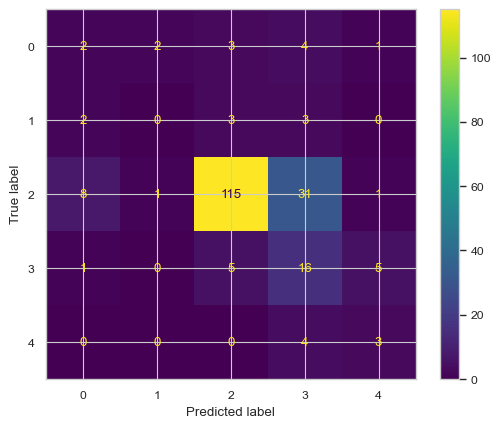

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("for param best : ", param_best)
predictions = clf_best.predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=clf_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_best.classes_)
disp.plot()
plt.show()

In [95]:
df_res_alpha[df_res_alpha["accuracy_test"] >= 0.64]

,nb_neurons,nb_iter,random_state,alpha,accuracy,accuracy_test
29,8.0,2000.0,2.0,0.0005,0.527070,0.642857
30,8.0,2000.0,2.0,0.0010,0.525478,0.642857
31,8.0,2000.0,2.0,0.0100,0.522293,0.642857
51,8.0,4000.0,2.0,0.0100,0.527070,0.647619


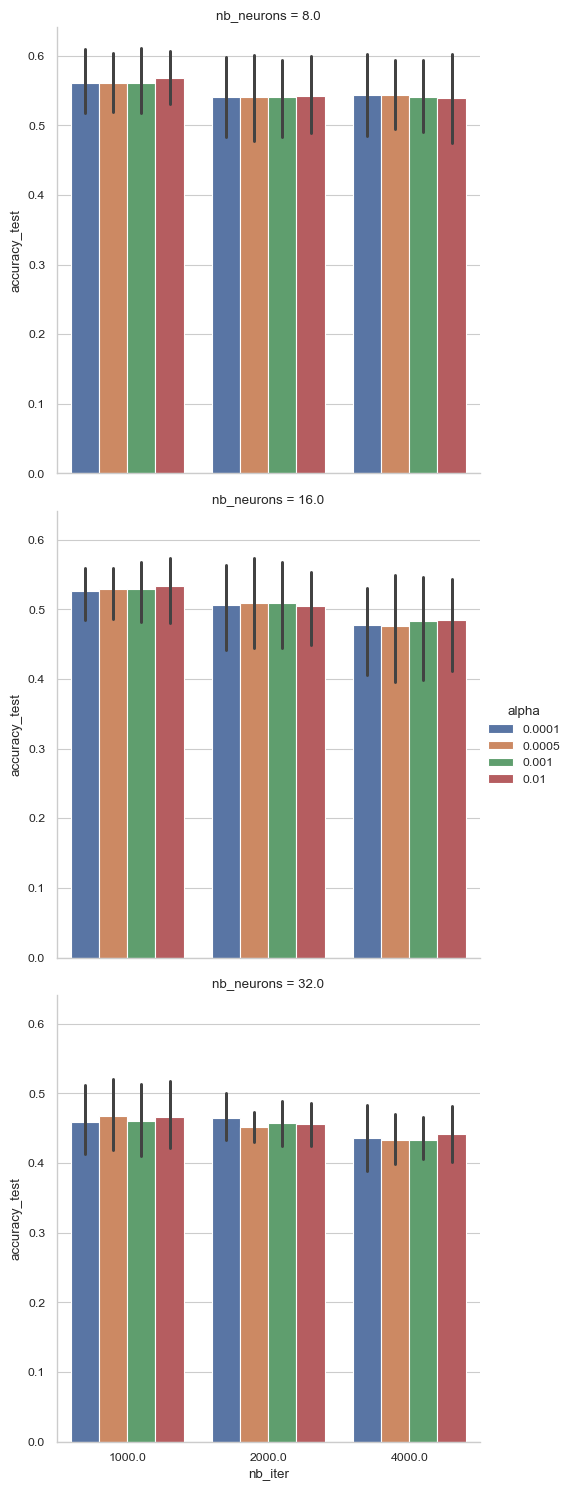

In [89]:
sns.catplot(data=df_res_alpha,
            kind="bar",
            x="nb_iter",
            y="accuracy_test",
            hue="alpha",
            row="nb_neurons")

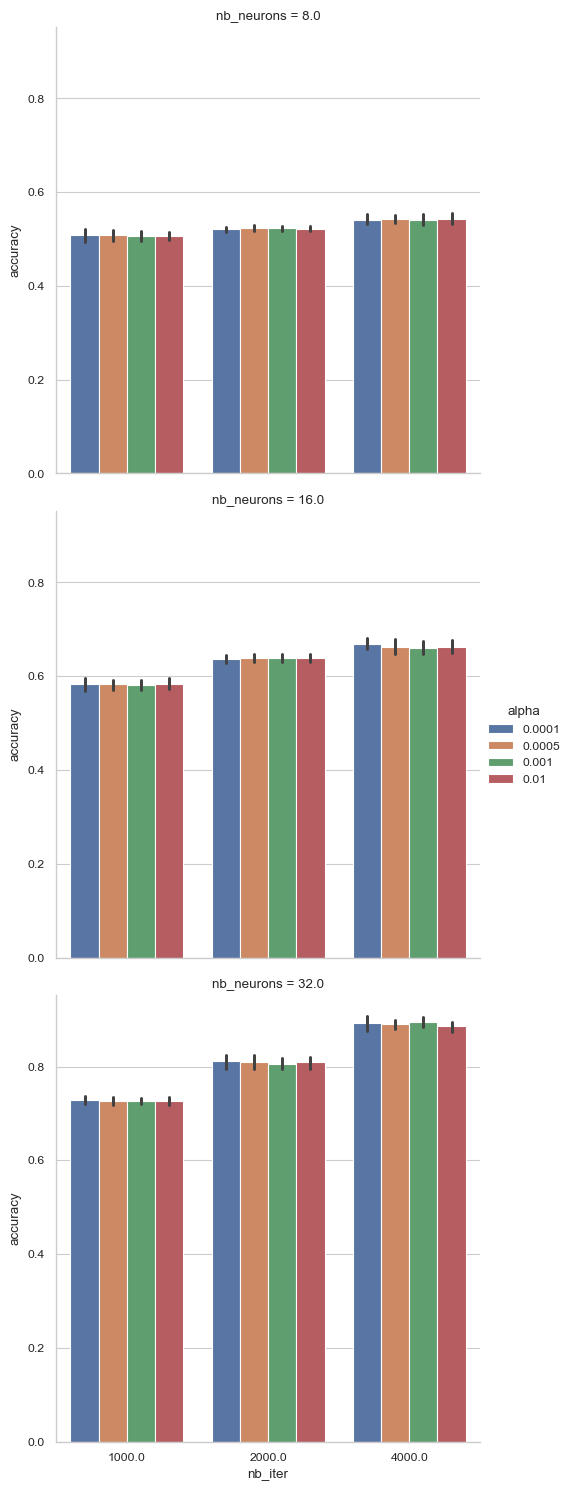

In [90]:
sns.catplot(data=df_res_alpha,
            kind="bar",
            x="nb_iter",
            y="accuracy",
            hue="alpha",
            row="nb_neurons")

### Best model

In [91]:
#16.0	2000.0	3.0	0.0001	0.660099	0.846154
clf = MLPClassifier(
    hidden_layer_sizes=(16),
    random_state=3, 
    max_iter=2000,
    n_iter_no_change=2000,
    alpha=0.0001,
)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TRAIN score : 0.6289808917197452
TEST score : 0.6095238095238096
Next month :  [4] 0.38572585251177766
nb iteration :  2000


/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


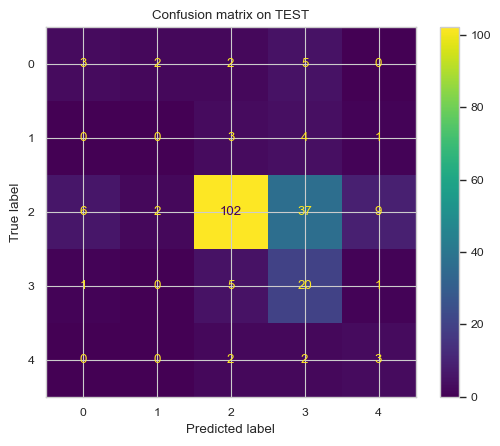

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = list_clf[0].predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=list_clf[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list_clf[0].classes_)
disp.plot()
plt.title("Confusion matrix on TEST")
plt.show()

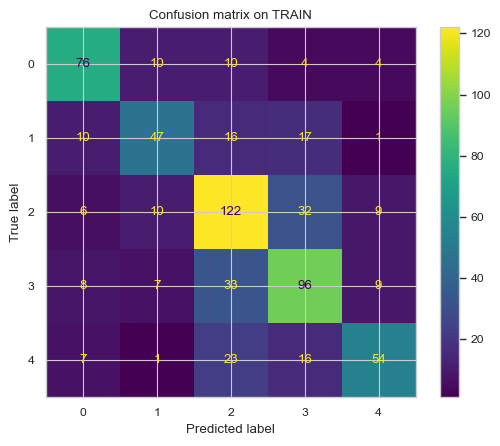

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = list_clf[0].predict(X)
cm = confusion_matrix(Y, predictions, labels=list_clf[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list_clf[0].classes_)
disp.plot()
plt.title("Confusion matrix on TRAIN")
plt.show()

Best : nb_neurons 32, nb_iter=4000,	random_state=3,	alpha=0.0100  

because False predictions are more homogenous between classes